## Testing all models on real time data

author: Akash Kharita
email: ak287@uw.edu
date: 09/27/2024


### objective

This notebook is created to analyze the results of all the models (3 machine learning and 4 deep learning models) tested on 531 events that were jiggled and assigned a label by analysts between 21 August to 23 September 2024, The models used are - 

1) ml_40 (P_10_30_F_05_15_50)
2) ml_110 (P_10_100_F_05_15_50)
3) ml_150 (P_50_100_F_05_15_50)

### working
The results of all models are calculated using another script, here we are just going to analyze those results.
For each event, I took 300s long window, 100s before the origin time and 200s after the origin time. The script downloads the data from all the jiggled stations for which three components are available. For each station, different model ran different length of windows (as detailed below) with 10s stride and provide probabilities for each of the classes (eq/px/su/noise). 

- ml_40 (40s, P-10, P+30)
- ml_110 (110s, P-10, P+100)
- ml_150 (150s, P-50, P+100)

all the deep learning models use window length of 100s. 


We have to download the probabilities of each model, the station data and the station ids. These data is stored in a zenodo repository. 



In [2]:
import os
import sys
import json
import pickle
import shutil
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from glob import glob
from time import time
from datetime import datetime
from scipy import stats, signal
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
import torchvision.transforms as transforms

import obspy
from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client

from joblib import dump, load

# Import custom utility functions and deep learning architectures
sys.path.append('../src')
from utils import apply_cosine_taper, butterworth_filter, resample_array




## Reading the catalog of real time events 

In [3]:
def return_stations_and_distances(data_string):
    # Step 1: Find the indices of the lists
    stations_start = data_string.index('[')
    stations_end = data_string.index(']') + 1
    distances_start = data_string.index('[', stations_end)
    distances_end = data_string.index(']', distances_start) + 1

    # Step 2: Extract and clean the lists
    stations_list = data_string[stations_start:stations_end].strip("[]").replace("'", "").split(', ')
    distances_list = list(map(int, data_string[distances_start:distances_end].strip("[]").split(', ')))

    return stations_list, distances_list

In [4]:
# Step 1: Read the text file
file_path = '../src/evid_netstas_for_akash.txt'  # Replace with your actual file name
with open(file_path, 'r') as f:
    lines = f.readlines()

# Step 2: Initialize data list
data = []

# Step 3: Process each line in the file
for line in lines:
    line = line.strip()
    
    try:
        stations_list, distances_list = return_stations_and_distances(line)
        parts = line.split()

        # Extract data
        event_id = parts[0]
        origin_id = parts[1]
        timestamp = f"{parts[2]} {parts[3]}"  # Timestamp (date and time)
        latitude = float(parts[4])
        longitude = float(parts[5])
        depth = float(parts[6])

        # Use regex to extract magnitude type and value
        match = re.match(r'([a-zA-Z]+)(-?[0-9]*\.?[0-9]+)', parts[7])
        magnitude_type = match.group(1)
        magnitude = float(match.group(2))

        min_dist = float(parts[8])
        max_dist = float(parts[9])
        event_type = parts[-1]

        # Append parsed data as a dictionary
        data.append({
            'event_id': event_id,
            'origin_id': origin_id,
            'timestamp': timestamp,
            'event_latitude': latitude,
            'event_longitude': longitude,
            'depth': depth,
            'magnitude_type': magnitude_type,
            'magnitude_value': magnitude,
            'min_distance': min_dist,
            'max_distance': max_dist,
            'stations': stations_list,
            'dist': distances_list,
            'analyst': event_type
        })
        
    except (ValueError, IndexError, AttributeError):
        # Catch only specific errors
        pass

# Step 4: Create a DataFrame
df1 = pd.DataFrame(data)

In [5]:
print(f'Total number of events in the catalog:{len(df1)}')
df1_labelled = df1[df1['analyst'] != 'N/A']

## removing the lf events.
df1_labelled = df1_labelled[df1_labelled['analyst'] != 'lf']

print(f'Total number of analyst labeled events in the catalog:{len(df1_labelled)}')

Total number of events in the catalog:1921
Total number of analyst labeled events in the catalog:531


In [6]:
df1_labelled.head()

,event_id,origin_id,timestamp,event_latitude,event_longitude,depth,magnitude_type,magnitude_value,min_distance,max_distance,stations,dist,analyst
0,61503223,3285348,2024-08-21 03:35:08.580000,48.659833,-122.031833,3.36,Ml,1.4,9.825605,44.209662,"[UW.SAXON, UW.MULN, UW.MBW2, UW.DONK, UW.SHUK,...","[10, 14, 18, 28, 34, 44]",eq
1,61503233,3285478,2024-08-22 16:28:23.510000,44.356000,-116.189167,14.62,Md,1.6,35.390196,110.512224,"[WW.CTNW, IW.PLID, IW.MFID, WW.IRMR]","[35, 83, 109, 111]",eq
2,61503238,3286293,2024-08-28 03:39:56.689999,45.367500,-121.701667,1.55,Ml,1.3,1.037543,19.201232,"[CC.PALM, CC.YOCR, CC.TIMB, CC.BRSP, CC.LSON, ...","[1, 4, 4, 4, 4, 11, 11, 17, 19]",eq
3,61503248,3287018,2024-08-31 22:16:20.619999,48.320000,-122.614667,21.56,Md,0.7,3.687938,44.698046,"[UW.SVOH, UW.PRIN, UW.HILL, UW.LOPEZ, UW.CWFG,...","[4, 12, 15, 24, 25, 35, 45]",eq
6,61503293,3290278,2024-09-21 18:20:31.090000,46.604000,-119.795667,7.70,Ml,0.7,2.648839,31.004845,"[UW.MDW, UW.CCRK, UW.BEN, UW.GBB, UW.SNI2, UW....","[3, 7, 11, 13, 19, 28, 31]",eq


## Loading the results of the script


The following code loads the results that were computed through a different script. For each of the labelled event in the catalog, models were run on the data from each mentioned station for which three components were available. The model was run on the 300s waveforms that started 100s before and 200s after the pick time/origin time. Each model computed the probabilities of eq, px, no and su for a window of fixed length and stride of 10s. 

### **The ML models (ml_40, ml_110, and ml_150) have slightly different output compared to deep learning models (mycnn_1d, mycnn_2d, seismiccnn_2d and myrescnn_2d).** 

For example probs_ml_40 is a list that has a shape of (number of events, number of stations, number of windows, 1, number of classes), on the other hand, probs_mycnn_1d is a list having a shape of (number of events, number of stations, 1, number of windows, and number of classes)

due to this difference in the structure of the output, we have to be a bit careful when analyzing the results


## station ids contain the stations for which results were computed and event ids contain event ids

## Downloading the results from zenodo repository

In [7]:
from zenodo_get import zenodo_get
doi = '10.5281/zenodo.13883279'
zenodo_get([doi])

Title: Output of all the models tested on the real time jiggled seismic events
Keywords: 
Publication date: 2024-10-03
DOI: 10.5281/zenodo.13883280
Total size: 2410.9 MB

Link: https://zenodo.org/record/13883280/files/probs_myrescnn_2d.pkl   size: 1.2 MB

Checksum is correct. (bf607ca4208bebc0eb5e4803d9be639c)

Link: https://zenodo.org/record/13883280/files/probs_ml_40.pkl   size: 5.5 MB

Checksum is correct. (dab55b26a58fca52acac85ef7c4f2017)

Link: https://zenodo.org/record/13883280/files/probs_ml_110.pkl   size: 4.1 MB

Checksum is correct. (49a74665a5e80611b81eaf9a57baa888)

Link: https://zenodo.org/record/13883280/files/station_ids.pkl   size: 0.2 MB

Checksum is correct. (8b875959142fbc17b5b9982072eb5f19)

Link: https://zenodo.org/record/13883280/files/probs_seismiccnn_2d.pkl   size: 1.2 MB

Checksum is correct. (a889e0f2673c687801213607a912a458)

Link: https://zenodo.org/record/13883280/files/station_data.pkl   size: 2393.1 MB

Checksum is correct. (61fafe649b22c82882f30aedb4785

In [8]:
# Open the file where the pickle object is stored
with open('probs_ml_40.pkl', 'rb') as file:
    # Load the pickle object
    probs_ml_40 = pickle.load(file)
    
# Open the file where the pickle object is stored
with open('probs_ml_110.pkl', 'rb') as file:
    # Load the pickle object
    probs_ml_110 = pickle.load(file)

# Open the file where the pickle object is stored
with open('probs_ml_150.pkl', 'rb') as file:
    # Load the pickle object
    probs_ml_150 = pickle.load(file)



# Open the file where the pickle object is stored
with open('probs_mycnn_1d.pkl', 'rb') as file:
    # Load the pickle object
    probs_mycnn_1d = pickle.load(file)

    
# Open the file where the pickle object is stored
with open('probs_mycnn_2d.pkl', 'rb') as file:
    # Load the pickle object
    probs_mycnn_2d = pickle.load(file)

    
# Open the file where the pickle object is stored
with open('probs_seismiccnn_2d.pkl', 'rb') as file:
    # Load the pickle object
    probs_seismiccnn_2d = pickle.load(file)
    
    
# Open the file where the pickle object is stored
with open('probs_myrescnn_2d.pkl', 'rb') as file:
    # Load the pickle object
    probs_myrescnn_2d = pickle.load(file)

    
# Open the file where the pickle object is stored
with open('evids.pkl', 'rb') as file:
    # Load the pickle object
    event_ids = pickle.load(file)
    
    
# Open the file where the pickle object is stored
with open('station_data.pkl', 'rb') as file:
    # Load the pickle object
    station_data = pickle.load(file)
    
# Open the file where the pickle object is stored
with open('station_ids.pkl', 'rb') as file:
    # Load the pickle object
    station_ids = pickle.load(file)
    
    

In [9]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".joblib"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)
        
# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".pkl"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)

## Extracting the maximum averaged probabilities of each class and assigning a label to an event

In [10]:
def extract_probs(probs_ml_40):
    max_eq_probs = []
    max_exp_probs = []
    max_no_probs = []
    max_su_probs = []
    evids = []
    
    
    for i in range(len(probs_ml_40)):
        try:
            new = np.array(probs_ml_40[i]).reshape(len(probs_ml_40[i]), -1, 4)
            max_avg_eq_prob, max_avg_exp_prob, max_avg_no_prob, max_avg_su_prob = np.max(np.mean(new, axis = 0), axis = 0)
            max_eq_probs.append(max_avg_eq_prob)
            max_exp_probs.append(max_avg_exp_prob)
            max_no_probs.append(max_avg_no_prob)
            max_su_probs.append(max_avg_su_prob)

            evids.append(event_ids[i])
        
        except:
            pass

    return max_eq_probs, max_exp_probs, max_no_probs, max_su_probs, evids

In [11]:
## setting the index of the dataframe
df1_labelled.index = df1_labelled['event_id']

# Extract probabilities for each model
eq_ml_40, exp_ml_40, no_ml_40, su_ml_40, evid_ml_40 = extract_probs(probs_ml_40)
eq_ml_110, exp_ml_110, no_ml_110, su_ml_110, evid_ml_110 = extract_probs(probs_ml_110)
eq_ml_150, exp_ml_150, no_ml_150, su_ml_150, evid_ml_150 = extract_probs(probs_ml_150)

eq_mycnn_1d, exp_mycnn_1d, no_mycnn_1d, su_mycnn_1d, evid_mycnn_1d = extract_probs(probs_mycnn_1d)
eq_mycnn_2d, exp_mycnn_2d, no_mycnn_2d, su_mycnn_2d, evid_mycnn_2d = extract_probs(probs_mycnn_2d)
eq_seismiccnn_2d, exp_seismiccnn_2d, no_seismiccnn_2d, su_seismiccnn_2d, evid_seismiccnn_2d = extract_probs(probs_seismiccnn_2d)
eq_myrescnn_2d, exp_myrescnn_2d, no_myrescnn_2d, su_myrescnn_2d, evid_myrescnn_2d = extract_probs(probs_myrescnn_2d)

# Use evidence from ml_40 for filtering
df_final = df1_labelled.loc[evid_ml_40]

# Add probabilities from ml_40 to the dataframe
df_final['eq_ml_40'] = eq_ml_40
df_final['exp_ml_40'] = exp_ml_40
df_final['no_ml_40'] = no_ml_40
df_final['su_ml_40'] = su_ml_40

# Add probabilities from other models to the dataframe
df_final['eq_ml_110'] = eq_ml_110
df_final['exp_ml_110'] = exp_ml_110
df_final['no_ml_110'] = no_ml_110
df_final['su_ml_110'] = su_ml_110

df_final['eq_ml_150'] = eq_ml_150
df_final['exp_ml_150'] = exp_ml_150
df_final['no_ml_150'] = no_ml_150
df_final['su_ml_150'] = su_ml_150

df_final['eq_mycnn_1d'] = eq_mycnn_1d
df_final['exp_mycnn_1d'] = exp_mycnn_1d
df_final['no_mycnn_1d'] = no_mycnn_1d
df_final['su_mycnn_1d'] = su_mycnn_1d

df_final['eq_mycnn_2d'] = eq_mycnn_2d
df_final['exp_mycnn_2d'] = exp_mycnn_2d
df_final['no_mycnn_2d'] = no_mycnn_2d
df_final['su_mycnn_2d'] = su_mycnn_2d

df_final['eq_seismiccnn_2d'] = eq_seismiccnn_2d
df_final['exp_seismiccnn_2d'] = exp_seismiccnn_2d
df_final['no_seismiccnn_2d'] = no_seismiccnn_2d
df_final['su_seismiccnn_2d'] = su_seismiccnn_2d

df_final['eq_myrescnn_2d'] = eq_myrescnn_2d
df_final['exp_myrescnn_2d'] = exp_myrescnn_2d
df_final['no_myrescnn_2d'] = no_myrescnn_2d
df_final['su_myrescnn_2d'] = su_myrescnn_2d

# Define a generic function to assign the label based on maximum probability for any model
def assign_label(row, eq_col, exp_col, su_col, threshold = 0.1):
    # Get the probabilities for eq, exp, su
    eq_prob = row[eq_col]
    exp_prob = row[exp_col]
    su_prob = row[su_col]
    
    # Find the maximum probability and its corresponding label
    max_prob = max(eq_prob, exp_prob, su_prob)
    
    # Assign the label based on the max probability and the threshold of 0.5
    if max_prob > threshold:
        if max_prob == eq_prob:
            return 'eq'
        elif max_prob == exp_prob:
            return 'px'
        elif max_prob == su_prob:
            return 'su'
    else:
        return 'no'  # Default label if no probability is greater than 0.5

# Apply the function for each model to create a new column for predictions
df_final['predict_ml_40'] = df_final.apply(assign_label, axis=1, args=('eq_ml_40', 'exp_ml_40', 'su_ml_40'))
df_final['predict_ml_110'] = df_final.apply(assign_label, axis=1, args=('eq_ml_110', 'exp_ml_110', 'su_ml_110'))
df_final['predict_ml_150'] = df_final.apply(assign_label, axis=1, args=('eq_ml_150', 'exp_ml_150', 'su_ml_150'))
df_final['predict_mycnn_1d'] = df_final.apply(assign_label, axis=1, args=('eq_mycnn_1d', 'exp_mycnn_1d', 'su_mycnn_1d'))
df_final['predict_mycnn_2d'] = df_final.apply(assign_label, axis=1, args=('eq_mycnn_2d', 'exp_mycnn_2d', 'su_mycnn_2d'))
df_final['predict_seismiccnn_2d'] = df_final.apply(assign_label, axis=1, args=('eq_seismiccnn_2d', 'exp_seismiccnn_2d', 'su_seismiccnn_2d'))
df_final['predict_myrescnn_2d'] = df_final.apply(assign_label, axis=1, args=('eq_myrescnn_2d', 'exp_myrescnn_2d', 'su_myrescnn_2d'))

# shifting the column to last position
col = df_final.pop('analyst')
df_final['analyst'] = col


## Threshold v/s accuracy for each model

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


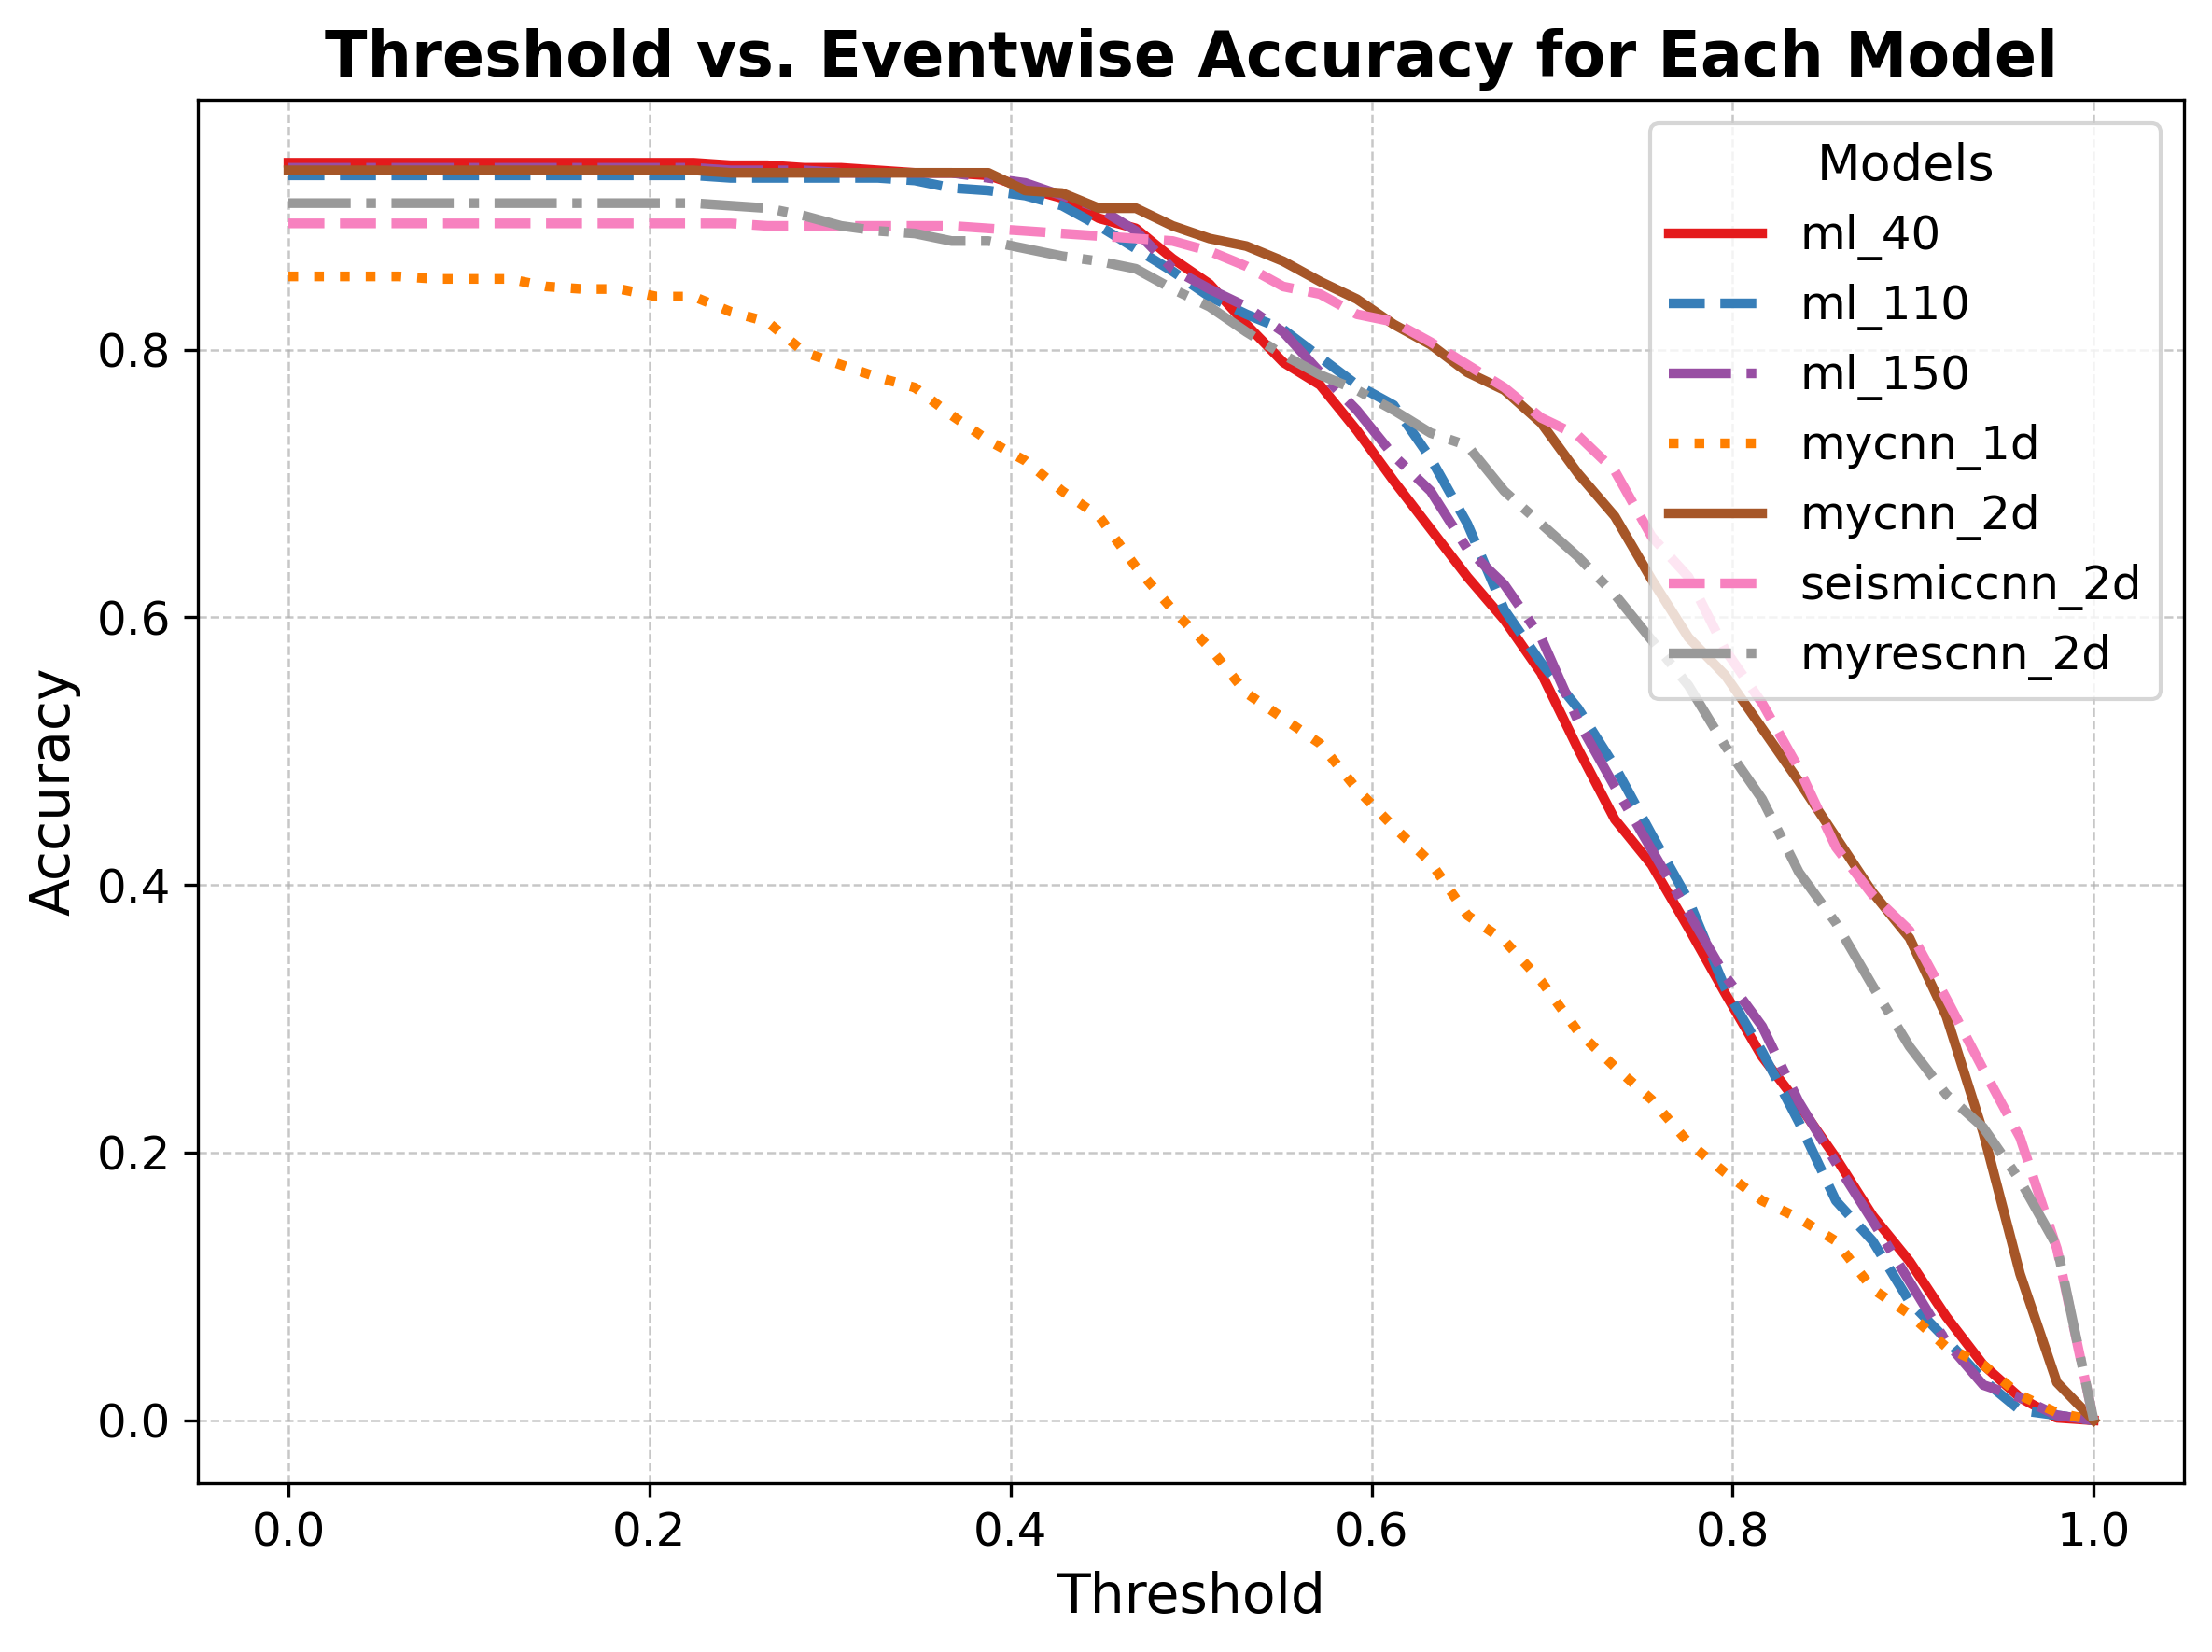

In [12]:
# Define the list of model prediction columns and corresponding probability columns
models = {
    'ml_40': ['eq_ml_40', 'exp_ml_40', 'su_ml_40'],
    'ml_110': ['eq_ml_110', 'exp_ml_110', 'su_ml_110'],
    'ml_150': ['eq_ml_150', 'exp_ml_150', 'su_ml_150'],
    'mycnn_1d': ['eq_mycnn_1d', 'exp_mycnn_1d', 'su_mycnn_1d'],
    'mycnn_2d': ['eq_mycnn_2d', 'exp_mycnn_2d', 'su_mycnn_2d'],
    'seismiccnn_2d': ['eq_seismiccnn_2d', 'exp_seismiccnn_2d', 'su_seismiccnn_2d'],
    'myrescnn_2d': ['eq_myrescnn_2d', 'exp_myrescnn_2d', 'su_myrescnn_2d']
}

# Define a range of thresholds
thresholds = np.linspace(0, 1, 50)

# Initialize the figure and adjust the size to better fit a research paper
plt.figure(figsize=(8, 6), dpi=300)

# Set a professional font style for all text
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": "Times New Roman",
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Define color palette and line styles
colors = plt.cm.get_cmap('Set1', len(models))  # Use Set1 colormap
linestyles = ['-', '--', '-.', ':', '-', '--', '-.']

# Function to compute accuracy at each threshold
def compute_accuracy_at_threshold(row, eq_prob, exp_prob, su_prob, threshold):
    max_prob = max(row[eq_prob], row[exp_prob], row[su_prob])
    if max_prob > threshold:
        if max_prob == row[eq_prob]:
            return 'eq'
        elif max_prob == row[exp_prob]:
            return 'px'
        elif max_prob == row[su_prob]:
            return 'su'
    else:
        return 'no'

# Loop through each model and calculate accuracy for different thresholds
for idx, (model_name, prob_cols) in enumerate(models.items()):
    accuracies = []
    
    for threshold in thresholds:
        # Apply the threshold logic and create predicted labels
        predictions = df_final.apply(compute_accuracy_at_threshold, axis=1, 
                                     args=(prob_cols[0], prob_cols[1], prob_cols[2], threshold))
        
        # Calculate the accuracy
        matches = (predictions == df_final['analyst']).sum()
        accuracy = matches / df_final.shape[0]
        accuracies.append(accuracy)
    
    # Plot accuracy vs. threshold for the current model
    plt.plot(thresholds, accuracies, label=model_name, color=colors(idx), linestyle=linestyles[idx], linewidth=2.5)

# Add plot details
plt.title('Threshold vs. Eventwise Accuracy for Each Model', fontsize=16, weight='bold')
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Position the legend at the side of the plot for clarity
plt.legend(loc='upper right', frameon=True, title="Models", title_fontsize=13)

# Subtle grid to enhance readability
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

# Save as a high-resolution figure suitable for publications
plt.tight_layout()
plt.savefig('threshold_vs_accuracy.pdf', format='pdf', bbox_inches='tight')  # Use PDF for publication quality
plt.show()


## Plotting the confusion matrix

We are going to plot the confusion matrix. 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


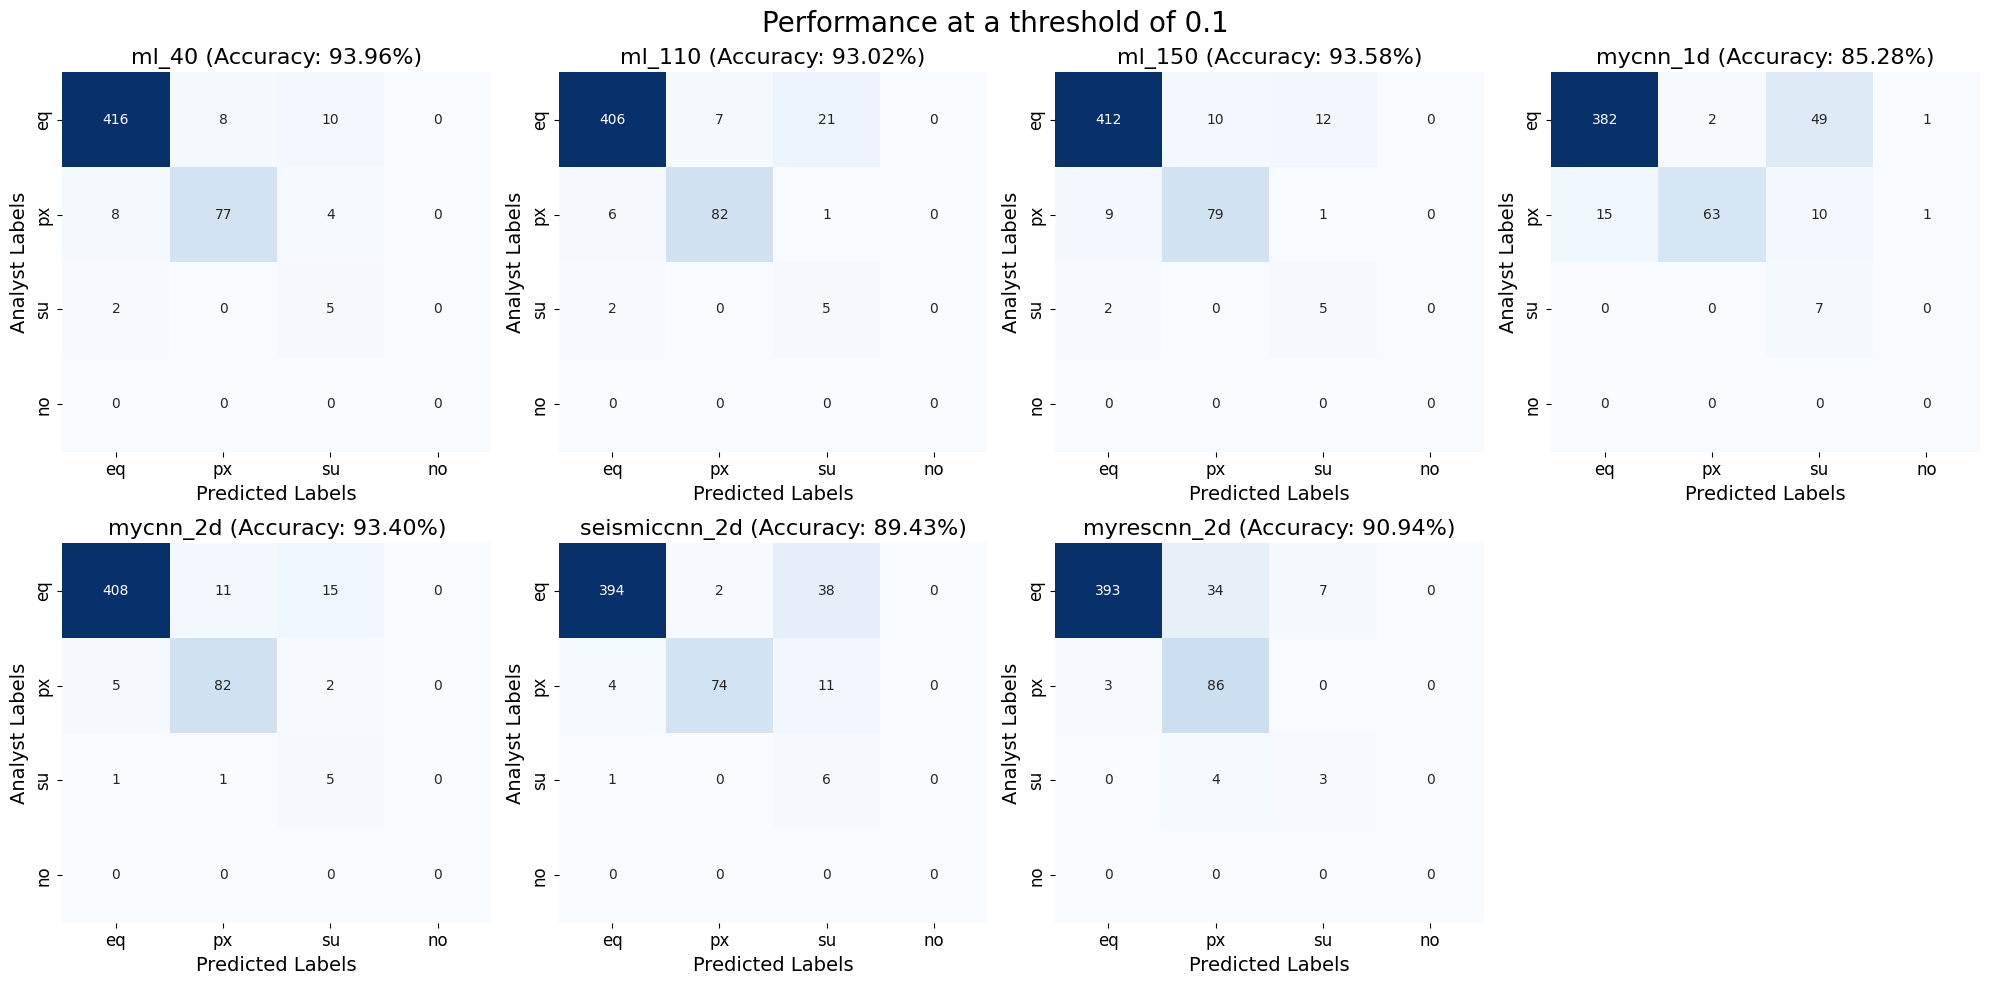

In [13]:
# Define the list of model prediction columns and corresponding probabilities columns
models = {
    'ml_40': ['eq_ml_40', 'exp_ml_40', 'su_ml_40'],
    'ml_110': ['eq_ml_110', 'exp_ml_110', 'su_ml_110'],
    'ml_150': ['eq_ml_150', 'exp_ml_150', 'su_ml_150'],
    'mycnn_1d': ['eq_mycnn_1d', 'exp_mycnn_1d', 'su_mycnn_1d'],
    'mycnn_2d': ['eq_mycnn_2d', 'exp_mycnn_2d', 'su_mycnn_2d'],
    'seismiccnn_2d': ['eq_seismiccnn_2d', 'exp_seismiccnn_2d', 'su_seismiccnn_2d'],
    'myrescnn_2d': ['eq_myrescnn_2d', 'exp_myrescnn_2d', 'su_myrescnn_2d']
}

threshold = 0.10
# Define a function to compute predictions based on a threshold of 0.5
def compute_predictions_at_threshold(row, eq_prob, exp_prob, su_prob, threshold= threshold):
    max_prob = max(row[eq_prob], row[exp_prob], row[su_prob])
    if max_prob > threshold:
        if max_prob == row[eq_prob]:
            return 'eq'
        elif max_prob == row[exp_prob]:
            return 'px'
        elif max_prob == row[su_prob]:
            return 'su'
    else:
        return 'no'

# Prepare the figure for subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns of subplots
axs = axs.flatten()  # Flatten for easy iteration over axes

# Loop through each model and plot the confusion matrix
for i, (model_name, prob_cols) in enumerate(models.items()):
    # Apply the 0.5 threshold and create predicted labels
    predictions = df_final.apply(compute_predictions_at_threshold, axis=1, 
                                 args=(prob_cols[0], prob_cols[1], prob_cols[2]))
    
    # Compute the confusion matrix
    cm = confusion_matrix(df_final['analyst'], predictions, labels=['eq', 'px', 'su', 'no'])
    
    # Calculate accuracy
    accuracy = accuracy_score(df_final['analyst'], predictions)
    
    # Plot the confusion matrix using seaborn's heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[i],
                xticklabels=['eq', 'px', 'su', 'no'], yticklabels=['eq', 'px', 'su', 'no'])
    
    # Set the title with model name and accuracy
    axs[i].set_title(f'{model_name} (Accuracy: {accuracy * 100:.2f}%)')
    axs[i].set_xlabel('Predicted Labels')
    axs[i].set_ylabel('Analyst Labels')

axs[-1].axis('off')
# Adjust layout and show plot

fig.suptitle(f'Performance at a threshold of {threshold}', fontsize = 20)
plt.tight_layout()
plt.show()


## Finding commonly misclassified events by all models

In [14]:
# Define a function to compute predictions based on a threshold of 0.5
def compute_predictions_at_threshold(row, eq_prob, exp_prob, su_prob, threshold=0.1):
    max_prob = max(row[eq_prob], row[exp_prob], row[su_prob])
    if max_prob > threshold:
        if max_prob == row[eq_prob]:
            return 'eq'
        elif max_prob == row[exp_prob]:
            return 'px'
        elif max_prob == row[su_prob]:
            return 'su'
    else:
        return 'no'

# Generate predictions for each model and check for misclassification
for model_name, prob_cols in models.items():
    
    # Create a column to indicate if the model's prediction matches the true label
    df_final[f'misclassified_{model_name}'] = df_final[f'predict_{model_name}'] != df_final['analyst']

# Now, find the rows where all models misclassified the events
misclassified_all_models = df_final.loc[
    (df_final['misclassified_ml_40']) &
    (df_final['misclassified_ml_110']) &
    (df_final['misclassified_ml_150']) &
    #(df_final['misclassified_mycnn_1d']) &
    (df_final['misclassified_mycnn_2d']) &
    (df_final['misclassified_seismiccnn_2d']) &
    (df_final['misclassified_myrescnn_2d'])
]

# Display the misclassified events
print("Commonly misclassified events by all models:")
print(misclassified_all_models[['analyst', 'predict_ml_40', 'predict_ml_110', 'predict_ml_150',
                                'predict_mycnn_1d', 'predict_mycnn_2d', 'predict_seismiccnn_2d', 
                                'predict_myrescnn_2d']])

misclassified_all_models.to_csv('../output/misclassified_events_by_all_models.csv')

Commonly misclassified events by all models:
         analyst predict_ml_40 predict_ml_110 predict_ml_150 predict_mycnn_1d  \
event_id                                                                        
62039026      eq            px             px             su               su   
62041636      px            eq             eq             eq               eq   
62042256      px            eq             eq             eq               eq   
62043616      px            eq             eq             eq               eq   
62043991      eq            px             px             px               px   
62044226      eq            px             su             px               eq   
62044301      eq            su             su             su               su   
62044791      eq            px             px             px               su   
62045401      eq            su             su             su               su   

         predict_mycnn_2d predict_seismiccnn_2d predict_myrescn

## Probability distance v/s accuracy

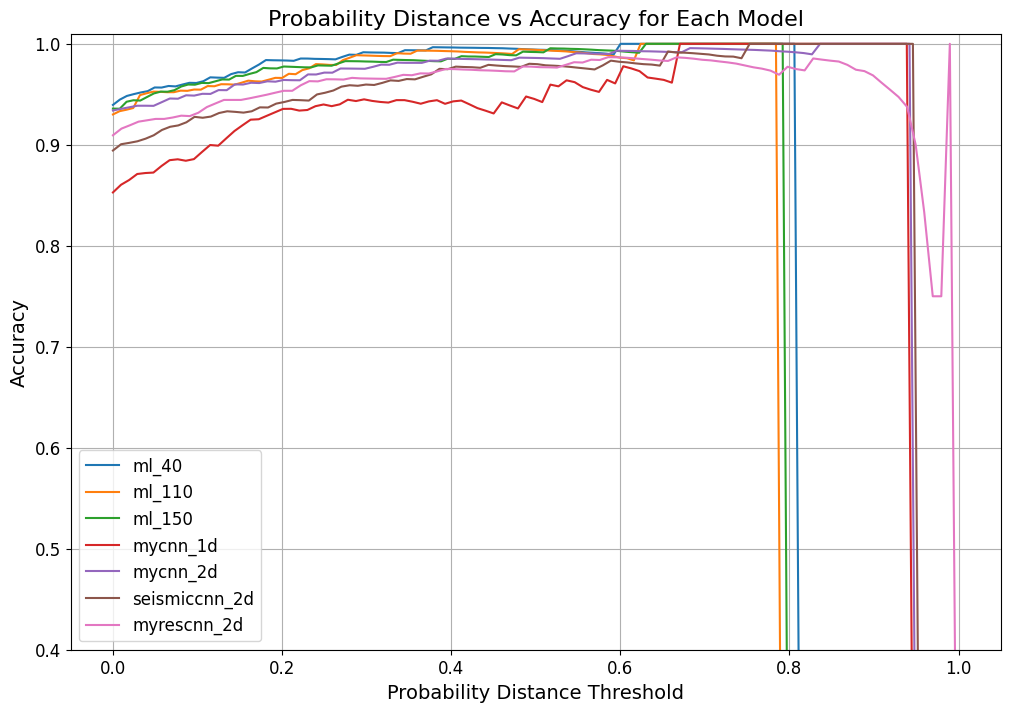

In [15]:
# Function to compute probability distances
def compute_probability_distances(df, prob_cols):
    distances = []
    
    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        probs = [row[prob_cols[0]], row[prob_cols[1]], row[prob_cols[2]]]
        max_prob = max(probs)
        sorted_probs = sorted(probs, reverse=True)
        second_max_prob = sorted_probs[1] if len(sorted_probs) > 1 else 0
        
        # Compute probability distance
        distance = max_prob - second_max_prob
        distances.append(distance)
    
    return distances

# Prepare the figure for plotting
plt.figure(figsize=(12, 8))

# Loop through each model to compute distances and plot accuracy
for model_name, prob_cols in models.items():
    # Calculate probability distances
    df_final[f'distance_{model_name}'] = compute_probability_distances(df_final, prob_cols)
    
    # Set up thresholds and accuracies
    distance_thresholds = np.linspace(0, df_final[f'distance_{model_name}'].max(), 100)
    accuracies = []

    # Calculate accuracy for each distance threshold
    for threshold in distance_thresholds:
        # Select events with a distance greater than the threshold
        selected_events = df_final[df_final[f'distance_{model_name}'] > threshold]
        
        if len(selected_events) > 0:
            # Calculate accuracy for these events
            accuracy = accuracy_score(selected_events['analyst'], selected_events[f'predict_{model_name}'])
        else:
            accuracy = 0  # If no events, set accuracy to 0

        accuracies.append(accuracy)

    # Plot the distance vs accuracy curve
    plt.plot(distance_thresholds, accuracies, label=model_name)

# Finalize the plot
plt.title('Probability Distance vs Accuracy for Each Model')
plt.xlabel('Probability Distance Threshold')
plt.ylabel('Accuracy')



plt.ylim(0.4,1.01)
plt.legend()

plt.grid()
plt.show()


## Distribution of the distances for misclassified events

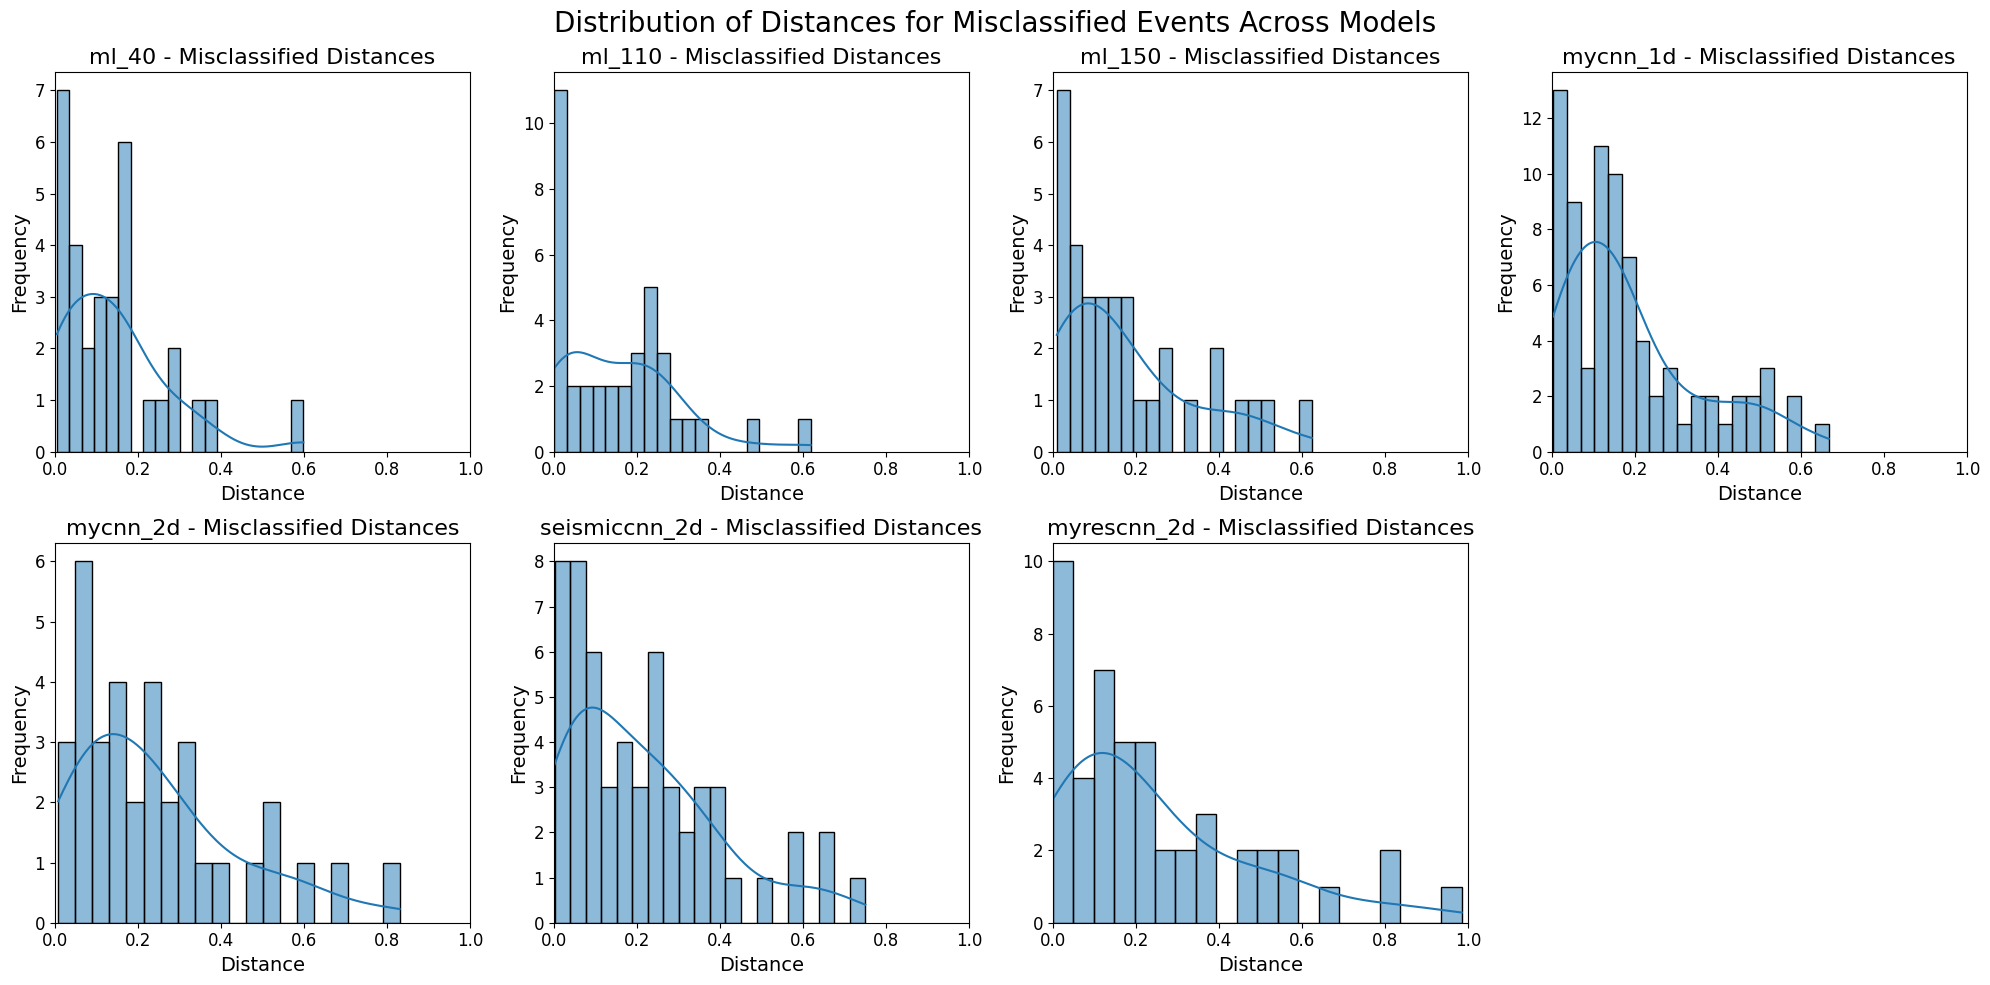

In [16]:
# Define the models and corresponding columns for predictions, misclassified flags, and distances
models_info = {
    'ml_40': {'prediction_col': 'predict_ml_40', 'misclassified_col': 'misclassified_ml_40', 'distance_col': 'distance_ml_40'},
    'ml_110': {'prediction_col': 'predict_ml_110', 'misclassified_col': 'misclassified_ml_110', 'distance_col': 'distance_ml_110'},
    'ml_150': {'prediction_col': 'predict_ml_150', 'misclassified_col': 'misclassified_ml_150', 'distance_col': 'distance_ml_150'},
    'mycnn_1d': {'prediction_col': 'predict_mycnn_1d', 'misclassified_col': 'misclassified_mycnn_1d', 'distance_col': 'distance_mycnn_1d'},
    'mycnn_2d': {'prediction_col': 'predict_mycnn_2d', 'misclassified_col': 'misclassified_mycnn_2d', 'distance_col': 'distance_mycnn_2d'},
    'seismiccnn_2d': {'prediction_col': 'predict_seismiccnn_2d', 'misclassified_col': 'misclassified_seismiccnn_2d', 'distance_col': 'distance_seismiccnn_2d'},
    'myrescnn_2d': {'prediction_col': 'predict_myrescnn_2d', 'misclassified_col': 'misclassified_myrescnn_2d', 'distance_col': 'distance_myrescnn_2d'}
}

# Prepare the figure for subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns of subplots
axs = axs.flatten()  # Flatten for easy iteration over axes

# Loop through each model and plot the histogram of misclassified distances
for i, (model_name, model_info) in enumerate(models_info.items()):
    # Filter misclassified events
    misclassified_events = df_final[df_final[model_info['misclassified_col']] == True]
    
    # Extract distances for misclassified events
    distances = misclassified_events[model_info['distance_col']]
    
    # Plot the histogram
    sns.histplot(distances, bins=20, kde=True, ax=axs[i])
    axs[i].set_title(f'{model_name} - Misclassified Distances')
    axs[i].set_xlabel('Distance')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(0,1)
# Remove the last empty plot (since we have 7 models and 8 subplots)
axs[-1].axis('off')

# Adjust layout and show plot
fig.suptitle('Distribution of Distances for Misclassified Events Across Models', fontsize=20)
plt.tight_layout()
plt.show()


## Plotting and Saving the results of all models for all events


## The code below plots the waveforms and results of all models and save them in a output directory

In [17]:
import matplotlib.lines as mlines
legend_elements = [
                mlines.Line2D([], [], marker='o', color='#FF0000', mec = 'k', label='Prob (Eq)', markersize= 8), 
                #mlines.Line2D([], [], marker='o', color='white', mec = 'k',  label='Prob (No)', markersize= 8),
                 mlines.Line2D([], [], marker='o', color='green', mec = 'k',  label='Prob (Exp)', markersize= 8),
            mlines.Line2D([], [], marker='o', color='blue', mec = 'k', label='Prob (Su)', markersize= 8)
            ]
    
# Function to apply the same plotting logic for all models
def plot_model_probs(ax, row, col, model_probs, data_shape, label, i, shift, title_prefix, win):
    eq_probs, exp_probs, _, su_probs = np.squeeze(np.array(model_probs[i])).T
    points = np.linspace(0, max(data_shape)/100 - win, len(eq_probs))

    # Plot the softmax probabilities with their labels
    ax[row, col].text(130, 2*i+1.15, 'eq:'+str(np.around(np.max(eq_probs), 2)))
    ax[row, col].text(150, 2*i+1.15, 'px:'+str(np.around(np.max(exp_probs), 2)))
    ax[row, col].text(170, 2*i+1.15, 'su:'+str(np.around(np.max(su_probs), 2)))

    # Scatter plot for probabilities
    ax[row, col].scatter(points + shift, eq_probs + 2*i, c= '#FF0000', ec='k')
    ax[row, col].scatter(points + shift, exp_probs + 2*i, c=  'green', ec='k')
    ax[row, col].scatter(points + shift, su_probs + 2*i, c=  'blue', ec='k')

    # Add title to the subplot
    ax[row, col].set_title(f'{title_prefix}, eq: {np.max(eq_probs):.2f}, '
                           f'px: {np.max(exp_probs):.2f}, '
                           f'su: {np.max(su_probs):.2f}, '
                           f'predict:{label}')
    
    ax[row, col].set_xlim(0,200)
    

    
    
    
# Average probability plotting
def plot_avg_probs(ax, row, col, avg_probs, shift, title_prefix, label, win):
    avg_eq_probs, avg_exp_probs, _, avg_su_probs = np.mean(np.squeeze(avg_probs), axis=0).T
    points = np.linspace(0, max(data[i].shape)/100 - win, len(avg_eq_probs))

    # Plot average probabilities
    ax[row, col].scatter(points + shift, avg_eq_probs - 2, c='#FF0000', ec = 'k')
    ax[row, col].scatter(points + shift, avg_exp_probs - 2, c='green', ec='k')
    ax[row, col].scatter(points + shift, avg_su_probs - 2, c='blue', ec='k')
    ax[row, col].axhline(-2, c='k')
    ax[row, col].set_title(f'{title_prefix}, eq: {np.max(avg_eq_probs):.2f},'
                           f'px: {np.max(avg_exp_probs):.2f}, '
                           f'su: {np.max(avg_su_probs):.2f}, '
                           f'predict: {label}')
    ax[row,col].set_xlim(0,200)

plt.style.use('default')

for i in tqdm(range(2)):
    
# uncomment this for doing this to all events
#for i in tqdm(range(len(df_final))):
    
    try:
    
        idx = np.where(np.array(event_ids) == df_final.index.values[i])[0][0]
        data = station_data[idx]
        stids = station_ids[idx]
        eventid = df_final.index.values[i]
        starttime_str = df_final['timestamp'].values[i]
        mag_type = df_final['magnitude_type'].values[i]
        mag_value = df_final['magnitude_value'].values[i]
        analyst = df_final['analyst'].values[i]




        temp_probs_ml_40 = probs_ml_40[idx]
        temp_probs_ml_110 = probs_ml_110[idx]
        temp_probs_ml_150 = probs_ml_150[idx]

        temp_probs_mycnn_2d = probs_mycnn_2d[idx]
        temp_probs_seismiccnn_2d = probs_seismiccnn_2d[idx]
        temp_probs_myrescnn_2d = probs_myrescnn_2d[idx]


        data = butterworth_filter(data, 1, 20)

        stns = df_final['stations'].values[i]
        dist = df_final['dist'].values[i]


        new_dist = []
        stns_list = []
        for k in range(len(stids)):
            if len(stids) > 1:
                single_stn = np.squeeze(stids)[k][0].split('.')[0]+'.'+np.squeeze(stids)[k][0].split('.')[1]
                stns_list.append(single_stn)
                new_dist.append(dist[np.where(np.array(stns) == single_stn)[0][0]])
            else:
                single_stn = np.squeeze(stids)[k].split('.')[0]+'.'+np.squeeze(stids)[k].split('.')[1]
                stns_list.append(single_stn)
                new_dist.append(dist[np.where(np.array(stns) == single_stn)[0][0]])

        stns = stns_list
        dist = new_dist

        ml_40_label = df_final['predict_ml_40'].values[i]
        ml_110_label = df_final['predict_ml_110'].values[i]
        ml_150_label = df_final['predict_ml_150'].values[i]

        mycnn_2d_label = df_final['predict_mycnn_2d'].values[i]
        seismiccnn_2d_label = df_final['predict_seismiccnn_2d'].values[i]
        myrescnn_2d_label = df_final['predict_myrescnn_2d'].values[i]





        # Main plotting code
        fig, ax = plt.subplots(2, 3, figsize=[20, 15], sharex=True, sharey=True)

        # Loop over stations to plot data and probabilities for different models
        for i in range(len(data)):
            t = np.linspace(0, max(data[i].shape)/100, max(data[i].shape))
            data[i] = np.squeeze(data[i])

            # Normalize and plot the Z component for each station
            for j in range(3):  # Iterate over the first 3 subplots
                ax[0, j].plot(t, data[i][2] / np.max(np.abs(data[i][2])) + 2*i, c= 'k', lw = 0.5, zorder = 1, alpha = 0.5)
                ax[1, j].plot(t, data[i][2] / np.max(np.abs(data[i][2])) + 2*i, c= 'k', lw = 0.5, zorder = 1, alpha = 0.5)

            # Plot probabilities for each model
            plot_model_probs(ax, 0, 0, temp_probs_ml_40, data[i].shape, ml_40_label, i, 10, 'ml_40', 40)
            plot_model_probs(ax, 0, 1, temp_probs_ml_110, data[i].shape, ml_110_label, i, 10, 'ml_110', 110)
            plot_model_probs(ax, 0, 2, temp_probs_ml_150, data[i].shape, ml_150_label, i, 50, 'ml_150', 150)
            plot_model_probs(ax, 1, 0, temp_probs_mycnn_2d, data[i].shape, mycnn_2d_label, i, 20, 'mycnn_2d', 100)
            plot_model_probs(ax, 1, 1, temp_probs_seismiccnn_2d, data[i].shape, seismiccnn_2d_label, i, 20, 'seismiccnn_2d', 100)
            plot_model_probs(ax, 1, 2, temp_probs_myrescnn_2d, data[i].shape, myrescnn_2d_label, i, 20, 'myrescnn_2d', 100)


        
        yticklabels = []
        for j in range(len(stns)):
            yticklabels.append(stns[j]+' '+str(dist[j])+'km')
        ax[0,0].set_yticks(np.arange(0, 2*len(stns), 2))
        ax[0,0].set_yticklabels(yticklabels)
        
        ax[-1,-1].legend(handles=legend_elements, loc='upper left', fontsize= 8)
        fig.suptitle(f'EventID:{eventid}, {starttime_str}, Mag:{mag_type}{mag_value},Analyst:{analyst}', fontsize = 15)
        fig.supxlabel('Time(s) since (origin time - 100s)')
        fig.tight_layout()
        
        
        
        plot_avg_probs(ax, 0, 0, temp_probs_ml_40, 10, 'ml_40', ml_40_label, 40)
        plot_avg_probs(ax, 0, 1, temp_probs_ml_110, 10, 'ml_110', ml_110_label, 110)
        plot_avg_probs(ax, 0, 2, temp_probs_ml_150, 50, 'ml_150', ml_150_label, 150)
        plot_avg_probs(ax, 1, 0, temp_probs_mycnn_2d, 20, 'mycnn_2d', mycnn_2d_label, 100)
        plot_avg_probs(ax, 1, 1, temp_probs_seismiccnn_2d, 20, 'seismiccnn_2d', seismiccnn_2d_label, 100)
        plot_avg_probs(ax, 1, 2, temp_probs_myrescnn_2d, 20, 'myrescnn_2d', myrescnn_2d_label, 100)






        # Final adjustments for yticks

        
        

        plt.savefig('../figures/all_model_detection_outputs/'+eventid+'.png')
        plt.close()
        plt.show()
        
    except:
        pass


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


## Copying the figures of misclassified events for a given model in a different directory

In [18]:
def copy_misclassified_images(df, model_col, analyst_col, source_dir, destination_dir):
    """
    Copies image files corresponding to misclassified events to the specified destination directory.
    
    Parameters:
    - df: DataFrame containing event data.
    - model_col: Column name for the model predictions.
    - analyst_col: Column name for the analyst's labels.
    - source_dir: Directory where all images are located.
    - destination_dir: Directory where misclassified images will be copied.
    """
    # Filter for misclassified events
    miss_df = df[df[model_col] != df[analyst_col]]
    
    # Get the list of event IDs
    event_ids = miss_df.index.values
    
    # Ensure the destination directory exists
    os.makedirs(destination_dir, exist_ok=True)

    # Copy each corresponding image to the destination
    for event_id in event_ids:
        file_name = f"{event_id}.png"
        source_path = os.path.join(source_dir, file_name)
        
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_dir)
            print(f"Copied {file_name} to {destination_dir}")
        else:
            print(f"File {file_name} not found in {source_dir}")

# Source directory where all images are stored
source_dir = '../figures/all_model_detection_outputs'

# Copy misclassified images for mycnn_2d model
copy_misclassified_images(
    df=df_final, 
    model_col='predict_mycnn_2d', 
    analyst_col='analyst', 
    source_dir=source_dir, 
    destination_dir='../figures/misclassified_mycnn_2d'
)

# Copy misclassified images for ml_40 model
copy_misclassified_images(
    df=df_final, 
    model_col='predict_ml_40', 
    analyst_col='analyst', 
    source_dir=source_dir, 
    destination_dir='../figures/misclassified_ml_40'
)



# Copy misclassified images for ml_40 model
copy_misclassified_images(
    df=misclassified_all_models, 
    model_col='predict_ml_40', 
    analyst_col='analyst', 
    source_dir=source_dir, 
    destination_dir='../figures/misclassified_all_models'
)


Copied 62037542.png to ../figures/misclassified_mycnn_2d
Copied 62037567.png to ../figures/misclassified_mycnn_2d
Copied 62037642.png to ../figures/misclassified_mycnn_2d
Copied 62037647.png to ../figures/misclassified_mycnn_2d
File 62039026.png not found in ../figures/all_model_detection_outputs
Copied 62039031.png to ../figures/misclassified_mycnn_2d
Copied 62039501.png to ../figures/misclassified_mycnn_2d
Copied 62040081.png to ../figures/misclassified_mycnn_2d
Copied 62040481.png to ../figures/misclassified_mycnn_2d
Copied 62041116.png to ../figures/misclassified_mycnn_2d
Copied 62041626.png to ../figures/misclassified_mycnn_2d
Copied 62041636.png to ../figures/misclassified_mycnn_2d
Copied 62042146.png to ../figures/misclassified_mycnn_2d
Copied 62042256.png to ../figures/misclassified_mycnn_2d
Copied 62042591.png to ../figures/misclassified_mycnn_2d
Copied 62042916.png to ../figures/misclassified_mycnn_2d
Copied 62043131.png to ../figures/misclassified_mycnn_2d
Copied 62043296.pn

## Estimating station wise performance


### For this we will create a dataframe that consists of event id, station id, station distance, snr, probability of each class for each model, labels predicted by each model, and maximum probability of a class for each model. 

In [19]:
df_stations = pd.DataFrame()
for i in range(len(df_final)):
    # Define labels
    labels_arr = np.array(['eq', 'px', 'no', 'su'])

    # Initialize data for event
    idx = np.where(np.array(event_ids) == df_final['event_id'].values[i])[0][0]
    
    
    stns = df_final['stations'].values[i]
    dist = df_final['dist'].values[i]

    # Process station IDs, dimension of stids are (no. of stations, 1, number of channels)
    stids = station_ids[idx]
    new_dist = []
    stns_list = []
    for k in range(len(stids)):

        single_stn = stids[k][0][0].split('.')[0] + '.' + stids[k][0][0].split('.')[1]
        stns_list.append(single_stn)
        new_dist.append(dist[np.where(np.array(stns) == single_stn)[0][0]])

    stns = stns_list
    dist = new_dist

    
    
    # Initialize SNR array
    snr_stns = []
    for m in range(len(station_data[idx])):
        # Define signal and noise windows
        sig_window = station_data[idx][m][0][-1][10000:15000]
        noise_window = station_data[idx][m][0][-1][0:5000]

        # Compute RMS signal and noise
        rms_signal = np.sqrt(np.mean(sig_window**2))
        rms_noise = np.sqrt(np.mean(noise_window**2))

        # Compute SNR (in dB)
        snr = rms_signal / rms_noise
        snr_stns.append(20 * np.log10(snr))

    # Function to process probabilities for a given model
    def process_model_probs(probs_model, stns_list):
        model_label_stns = []
        probs_label_stns = []
        
        new = np.array(probs_model).reshape(len(probs_model), -1, 4)

        for j in range(len(new)):
            probs_label_stns.append(np.max(new[j], axis=0))

        for k in range(len(np.array(probs_label_stns))):
            if np.argsort(probs_label_stns[k])[-1] == 2:
                model_label_stns.append(labels_arr[np.argsort(probs_label_stns[k])[-2]])
            else:
                model_label_stns.append(labels_arr[np.argsort(probs_label_stns[k])[-1]])

        return np.array(probs_label_stns), model_label_stns

    # Process model probabilities for different models
    new_probs_ml_40, predict_ml_40 = process_model_probs(probs_ml_40[idx], stns_list)
    new_probs_ml_110, predict_ml_110 = process_model_probs(probs_ml_110[idx], stns_list)
    new_probs_ml_150, predict_ml_150 = process_model_probs(probs_ml_150[idx], stns_list)
    new_probs_mycnn_1d, predict_mycnn_1d = process_model_probs(probs_mycnn_1d[idx], stns_list)
    new_probs_mycnn_2d, predict_mycnn_2d = process_model_probs(probs_mycnn_2d[idx], stns_list)
    new_probs_seismiccnn_2d, predict_seismiccnn_2d = process_model_probs(probs_seismiccnn_2d[idx], stns_list)
    new_probs_myrescnn_2d, predict_myrescnn_2d = process_model_probs(probs_myrescnn_2d[idx], stns_list)

    # Create DataFrame and add the data for each model
    df = pd.DataFrame({
        'stations': stns,
        'distances': dist,
        'analyst': [df_final['analyst'].values[i]] * len(stns_list),
        'predict_ml_40': predict_ml_40,
        'predict_ml_110': predict_ml_110,
        'predict_ml_150': predict_ml_150,
        'predict_mycnn_1d': predict_mycnn_1d,
        'predict_mycnn_2d': predict_mycnn_2d,
        'predict_seismiccnn_2d': predict_seismiccnn_2d,
        'predict_myrescnn_2d': predict_myrescnn_2d,
        'snr': snr_stns,
        'eq_ml_40': new_probs_ml_40[:, 0],
        'exp_ml_40': new_probs_ml_40[:, 1],
        'no_ml_40': new_probs_ml_40[:, 2],
        'su_ml_40': new_probs_ml_40[:, 3],
        'eq_ml_110': new_probs_ml_110[:, 0],
        'exp_ml_110': new_probs_ml_110[:, 1],
        'no_ml_110': new_probs_ml_110[:, 2],
        'su_ml_110': new_probs_ml_110[:, 3],
        'eq_ml_150': new_probs_ml_150[:, 0],
        'exp_ml_150': new_probs_ml_150[:, 1],
        'no_ml_150': new_probs_ml_150[:, 2],
        'su_ml_150': new_probs_ml_150[:, 3],
        'eq_mycnn_1d': new_probs_mycnn_1d[:, 0],
        'exp_mycnn_1d': new_probs_mycnn_1d[:, 1],
        'no_mycnn_1d': new_probs_mycnn_1d[:, 2],
        'su_mycnn_1d': new_probs_mycnn_1d[:, 3],
        'eq_mycnn_2d': new_probs_mycnn_2d[:, 0],
        'exp_mycnn_2d': new_probs_mycnn_2d[:, 1],
        'no_mycnn_2d': new_probs_mycnn_2d[:, 2],
        'su_mycnn_2d': new_probs_mycnn_2d[:, 3],
        'eq_seismiccnn_2d': new_probs_seismiccnn_2d[:, 0],
        'exp_seismiccnn_2d': new_probs_seismiccnn_2d[:, 1],
        'no_seismiccnn_2d': new_probs_seismiccnn_2d[:, 2],
        'su_seismiccnn_2d': new_probs_seismiccnn_2d[:, 3],
        'eq_myrescnn_2d': new_probs_myrescnn_2d[:, 0],
        'exp_myrescnn_2d': new_probs_myrescnn_2d[:, 1],
        'no_myrescnn_2d': new_probs_myrescnn_2d[:, 2],
        'su_myrescnn_2d': new_probs_myrescnn_2d[:, 3]
    })

    # Set event ID as index
    df.index = [event_ids[idx]] * len(stns)

    # Output the DataFrame
    df_stations = pd.concat([df_stations, df])


In [20]:
df_stations.head()

,stations,distances,analyst,predict_ml_40,predict_ml_110,predict_ml_150,predict_mycnn_1d,predict_mycnn_2d,predict_seismiccnn_2d,predict_myrescnn_2d,snr,eq_ml_40,exp_ml_40,no_ml_40,su_ml_40,eq_ml_110,exp_ml_110,no_ml_110,su_ml_110,eq_ml_150,exp_ml_150,no_ml_150,su_ml_150,eq_mycnn_1d,exp_mycnn_1d,no_mycnn_1d,su_mycnn_1d,eq_mycnn_2d,exp_mycnn_2d,no_mycnn_2d,su_mycnn_2d,eq_seismiccnn_2d,exp_seismiccnn_2d,no_seismiccnn_2d,su_seismiccnn_2d,eq_myrescnn_2d,exp_myrescnn_2d,no_myrescnn_2d,su_myrescnn_2d
61503223,UW.SAXON,10,eq,eq,eq,eq,eq,eq,eq,eq,9.861983,0.854,0.208,0.988,0.158,0.950,0.086,0.882,0.442,0.950,0.106,0.868,0.404,0.982700,0.155467,0.993687,0.864462,0.987675,0.045603,0.996898,0.115453,0.999957,0.053622,0.984570,0.416244,0.991506,0.203085,0.999992,0.455505
61503223,UW.MULN,14,eq,eq,eq,eq,su,eq,eq,eq,18.513825,0.914,0.300,0.960,0.470,0.918,0.116,0.898,0.512,0.942,0.080,0.926,0.392,0.840366,0.222226,0.993736,0.876113,0.940953,0.068016,0.995936,0.723160,0.994367,0.016310,0.982948,0.865707,0.972328,0.371875,1.000000,0.040718
61503223,UW.MBW2,18,eq,eq,eq,eq,eq,eq,eq,eq,4.086573,0.954,0.412,1.000,0.440,0.980,0.156,0.998,0.454,0.968,0.264,0.974,0.312,0.880737,0.134344,0.998516,0.792022,0.989127,0.150942,0.995873,0.378617,0.999432,0.089123,0.998794,0.468731,0.998586,0.105447,0.999919,0.220724
61503223,UW.DONK,28,eq,eq,eq,eq,eq,eq,eq,eq,-1.395581,0.976,0.282,0.998,0.362,0.978,0.104,1.000,0.268,0.974,0.152,0.990,0.242,0.977813,0.014038,0.998011,0.290019,0.987141,0.036496,0.997322,0.110850,0.998578,0.032859,0.999290,0.012953,0.999329,0.208952,0.999994,0.180191
61503223,UW.SHUK,34,eq,eq,eq,eq,su,eq,eq,eq,-0.027120,0.834,0.200,0.996,0.344,0.798,0.164,1.000,0.344,0.756,0.094,0.996,0.438,0.365824,0.113259,0.991741,0.374330,0.979144,0.015827,0.996115,0.033706,0.997415,0.037044,0.997686,0.022349,0.999234,0.039821,0.999999,0.056202


## Plotting station wise accuracies

Accuracy for predict_ml_40: 0.8645
Accuracy for predict_ml_110: 0.8674
Accuracy for predict_ml_150: 0.8815
Accuracy for predict_mycnn_1d: 0.7629
Accuracy for predict_mycnn_2d: 0.8680
Accuracy for predict_seismiccnn_2d: 0.7807
Accuracy for predict_myrescnn_2d: 0.8229


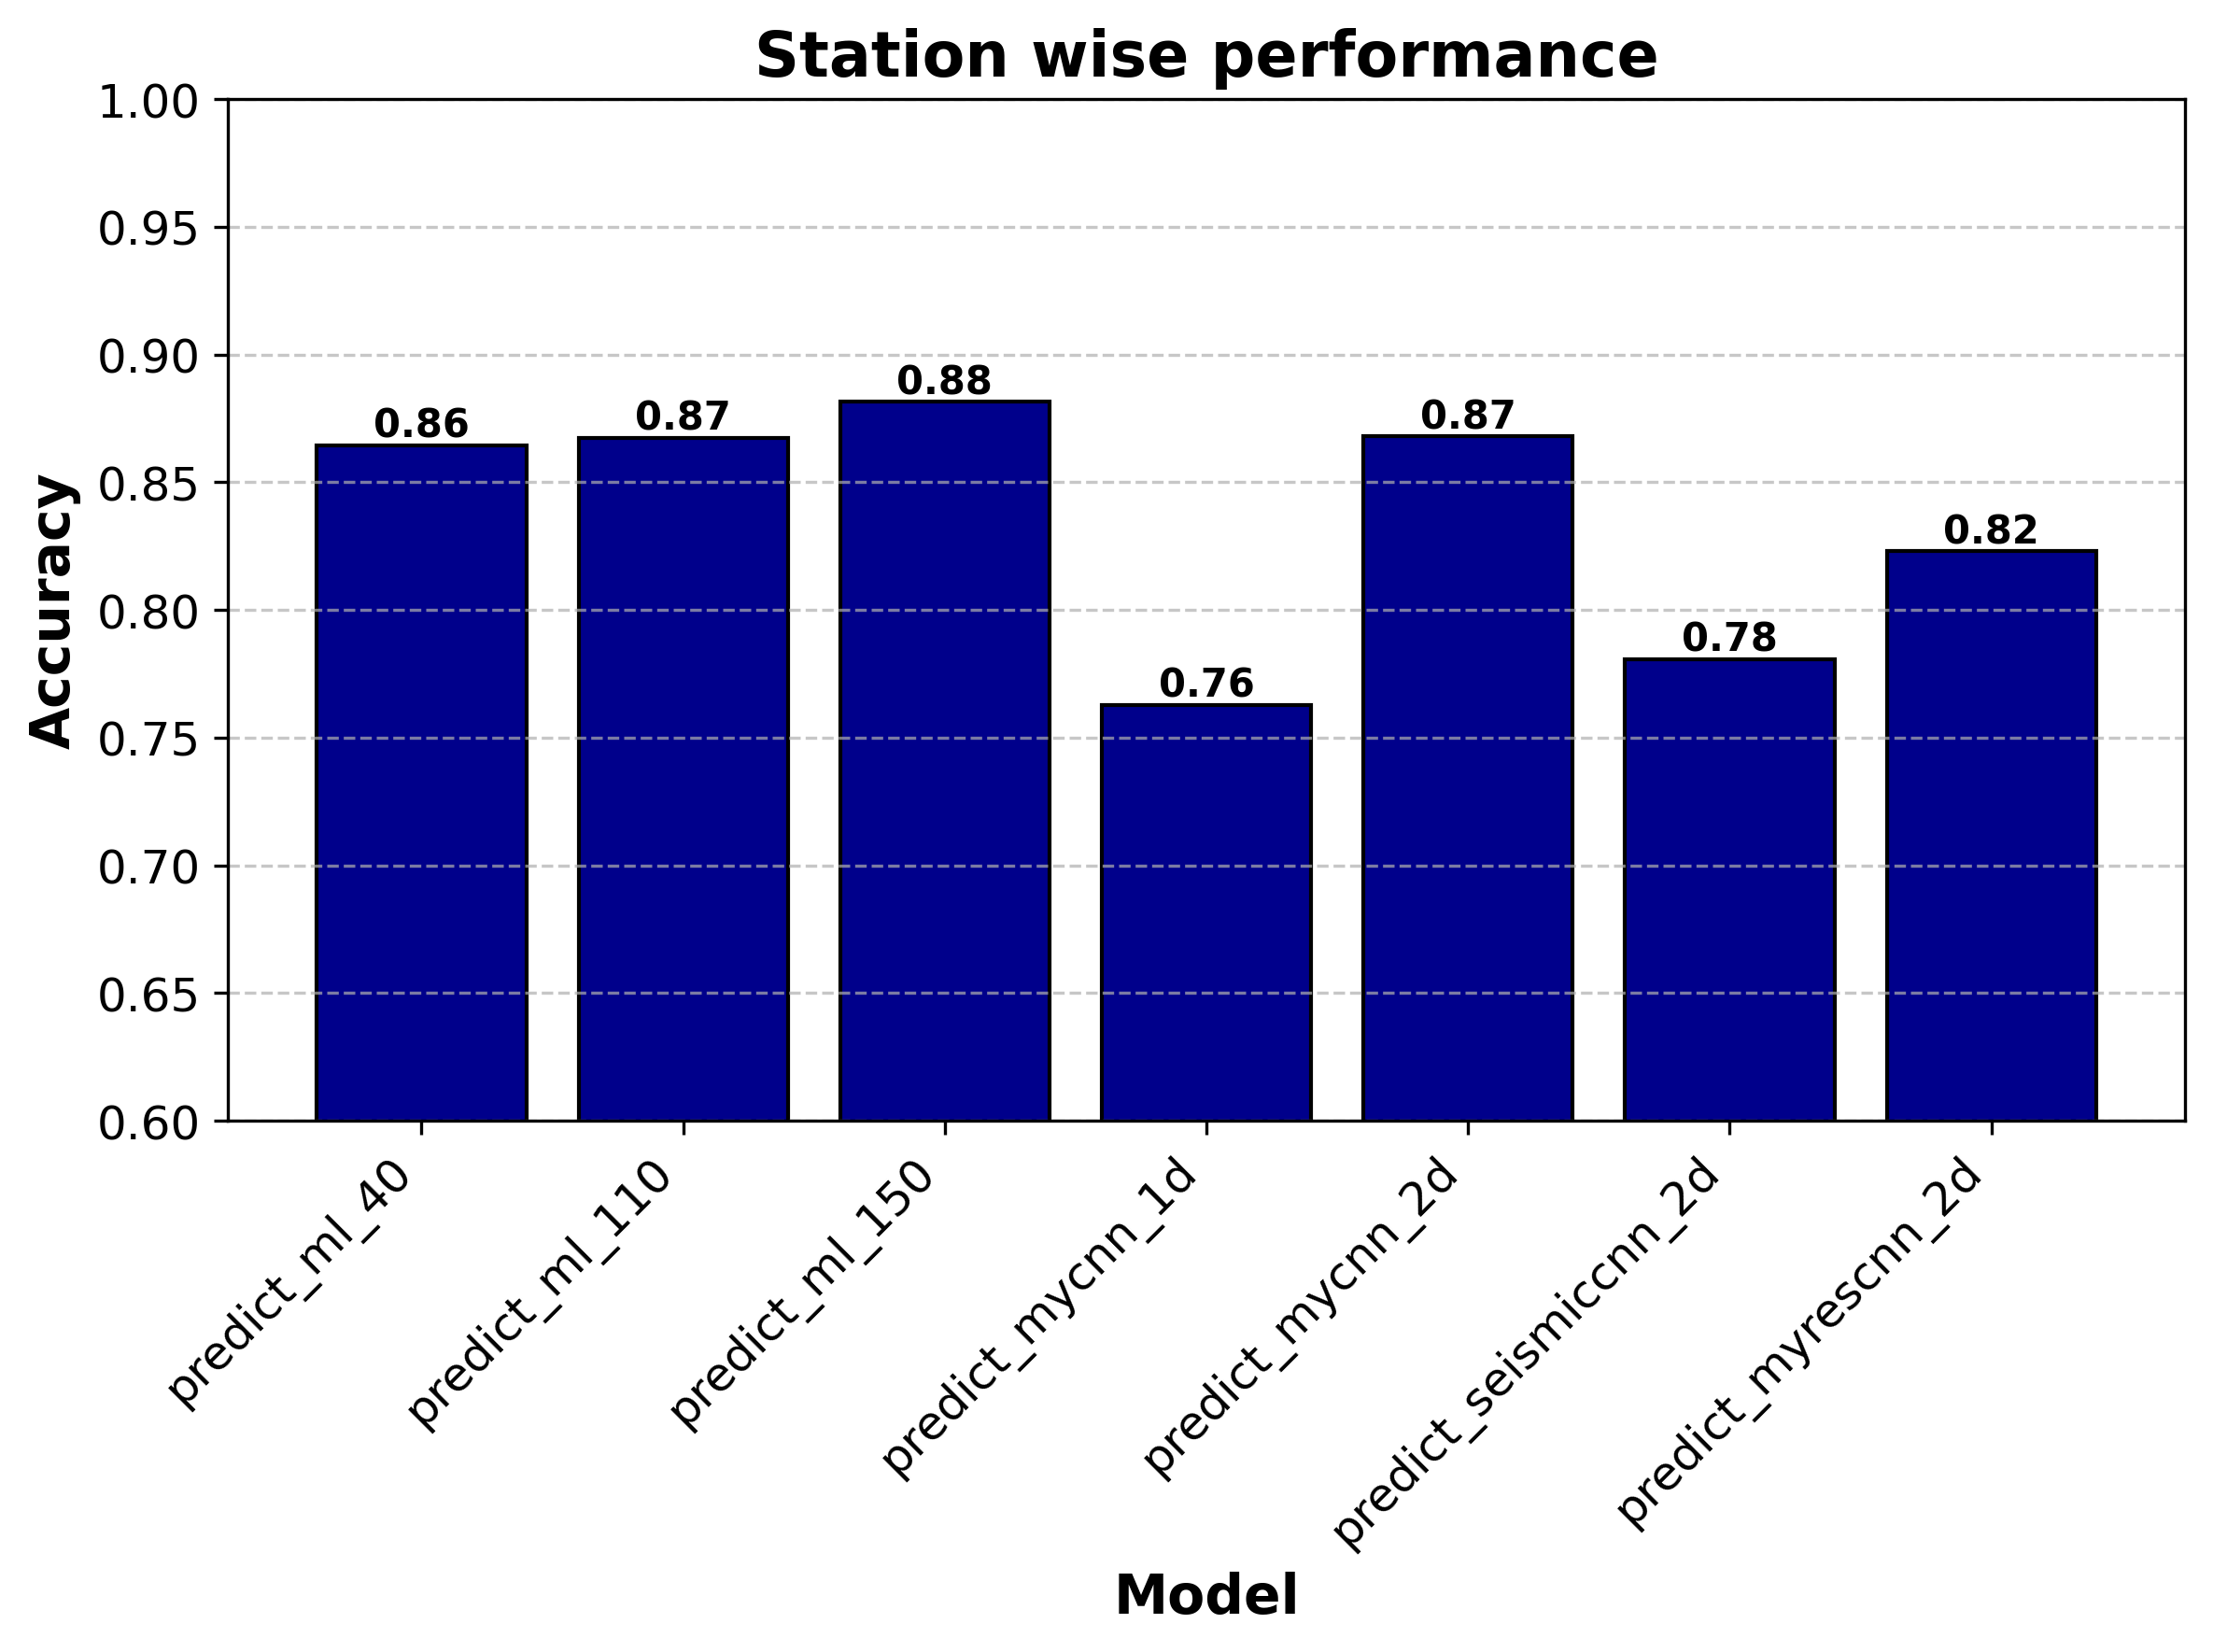

In [21]:
# List of model columns for prediction
model_columns = [
    'predict_ml_40', 'predict_ml_110', 'predict_ml_150', 
    'predict_mycnn_1d', 'predict_mycnn_2d', 
    'predict_seismiccnn_2d', 'predict_myrescnn_2d'
]

# Dictionary to store the accuracy for each model
accuracy_dict = {}

# Loop through each model column and calculate accuracy
for model in model_columns:
    correct_predictions = (df_stations[model] == df_stations['analyst']).sum()
    total_predictions = len(df_stations)
    accuracy = correct_predictions / total_predictions
    accuracy_dict[model] = accuracy

# Display the accuracy for each model
for model, accuracy in accuracy_dict.items():
    print(f"Accuracy for {model}: {accuracy:.4f}")
    
    
# Extract model names and accuracies
models = list(accuracy_dict.keys())
accuracies = list(accuracy_dict.values())

# Set figure size for a professional research-quality look
plt.figure(figsize=(8, 6), dpi=300)

# Create bar plot
bars = plt.bar(models, accuracies, color='darkblue', edgecolor='black')

# Add labels and title
plt.xlabel('Model', fontsize=14, weight='bold')
plt.ylabel('Accuracy', fontsize=14, weight='bold')
plt.title('Station wise performance', fontsize=16, weight='bold')

# Customize axis ticks
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add accuracy values on top of bars with professional formatting
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# setting ylim
plt.ylim(0.6,1)

# Ensure tight layout for presentation
plt.tight_layout()

# Show plot
plt.show()



Accuracy for predict_ml_40: 0.9396
Accuracy for predict_ml_110: 0.9302
Accuracy for predict_ml_150: 0.9358
Accuracy for predict_mycnn_1d: 0.8528
Accuracy for predict_mycnn_2d: 0.9340
Accuracy for predict_seismiccnn_2d: 0.8943
Accuracy for predict_myrescnn_2d: 0.9094


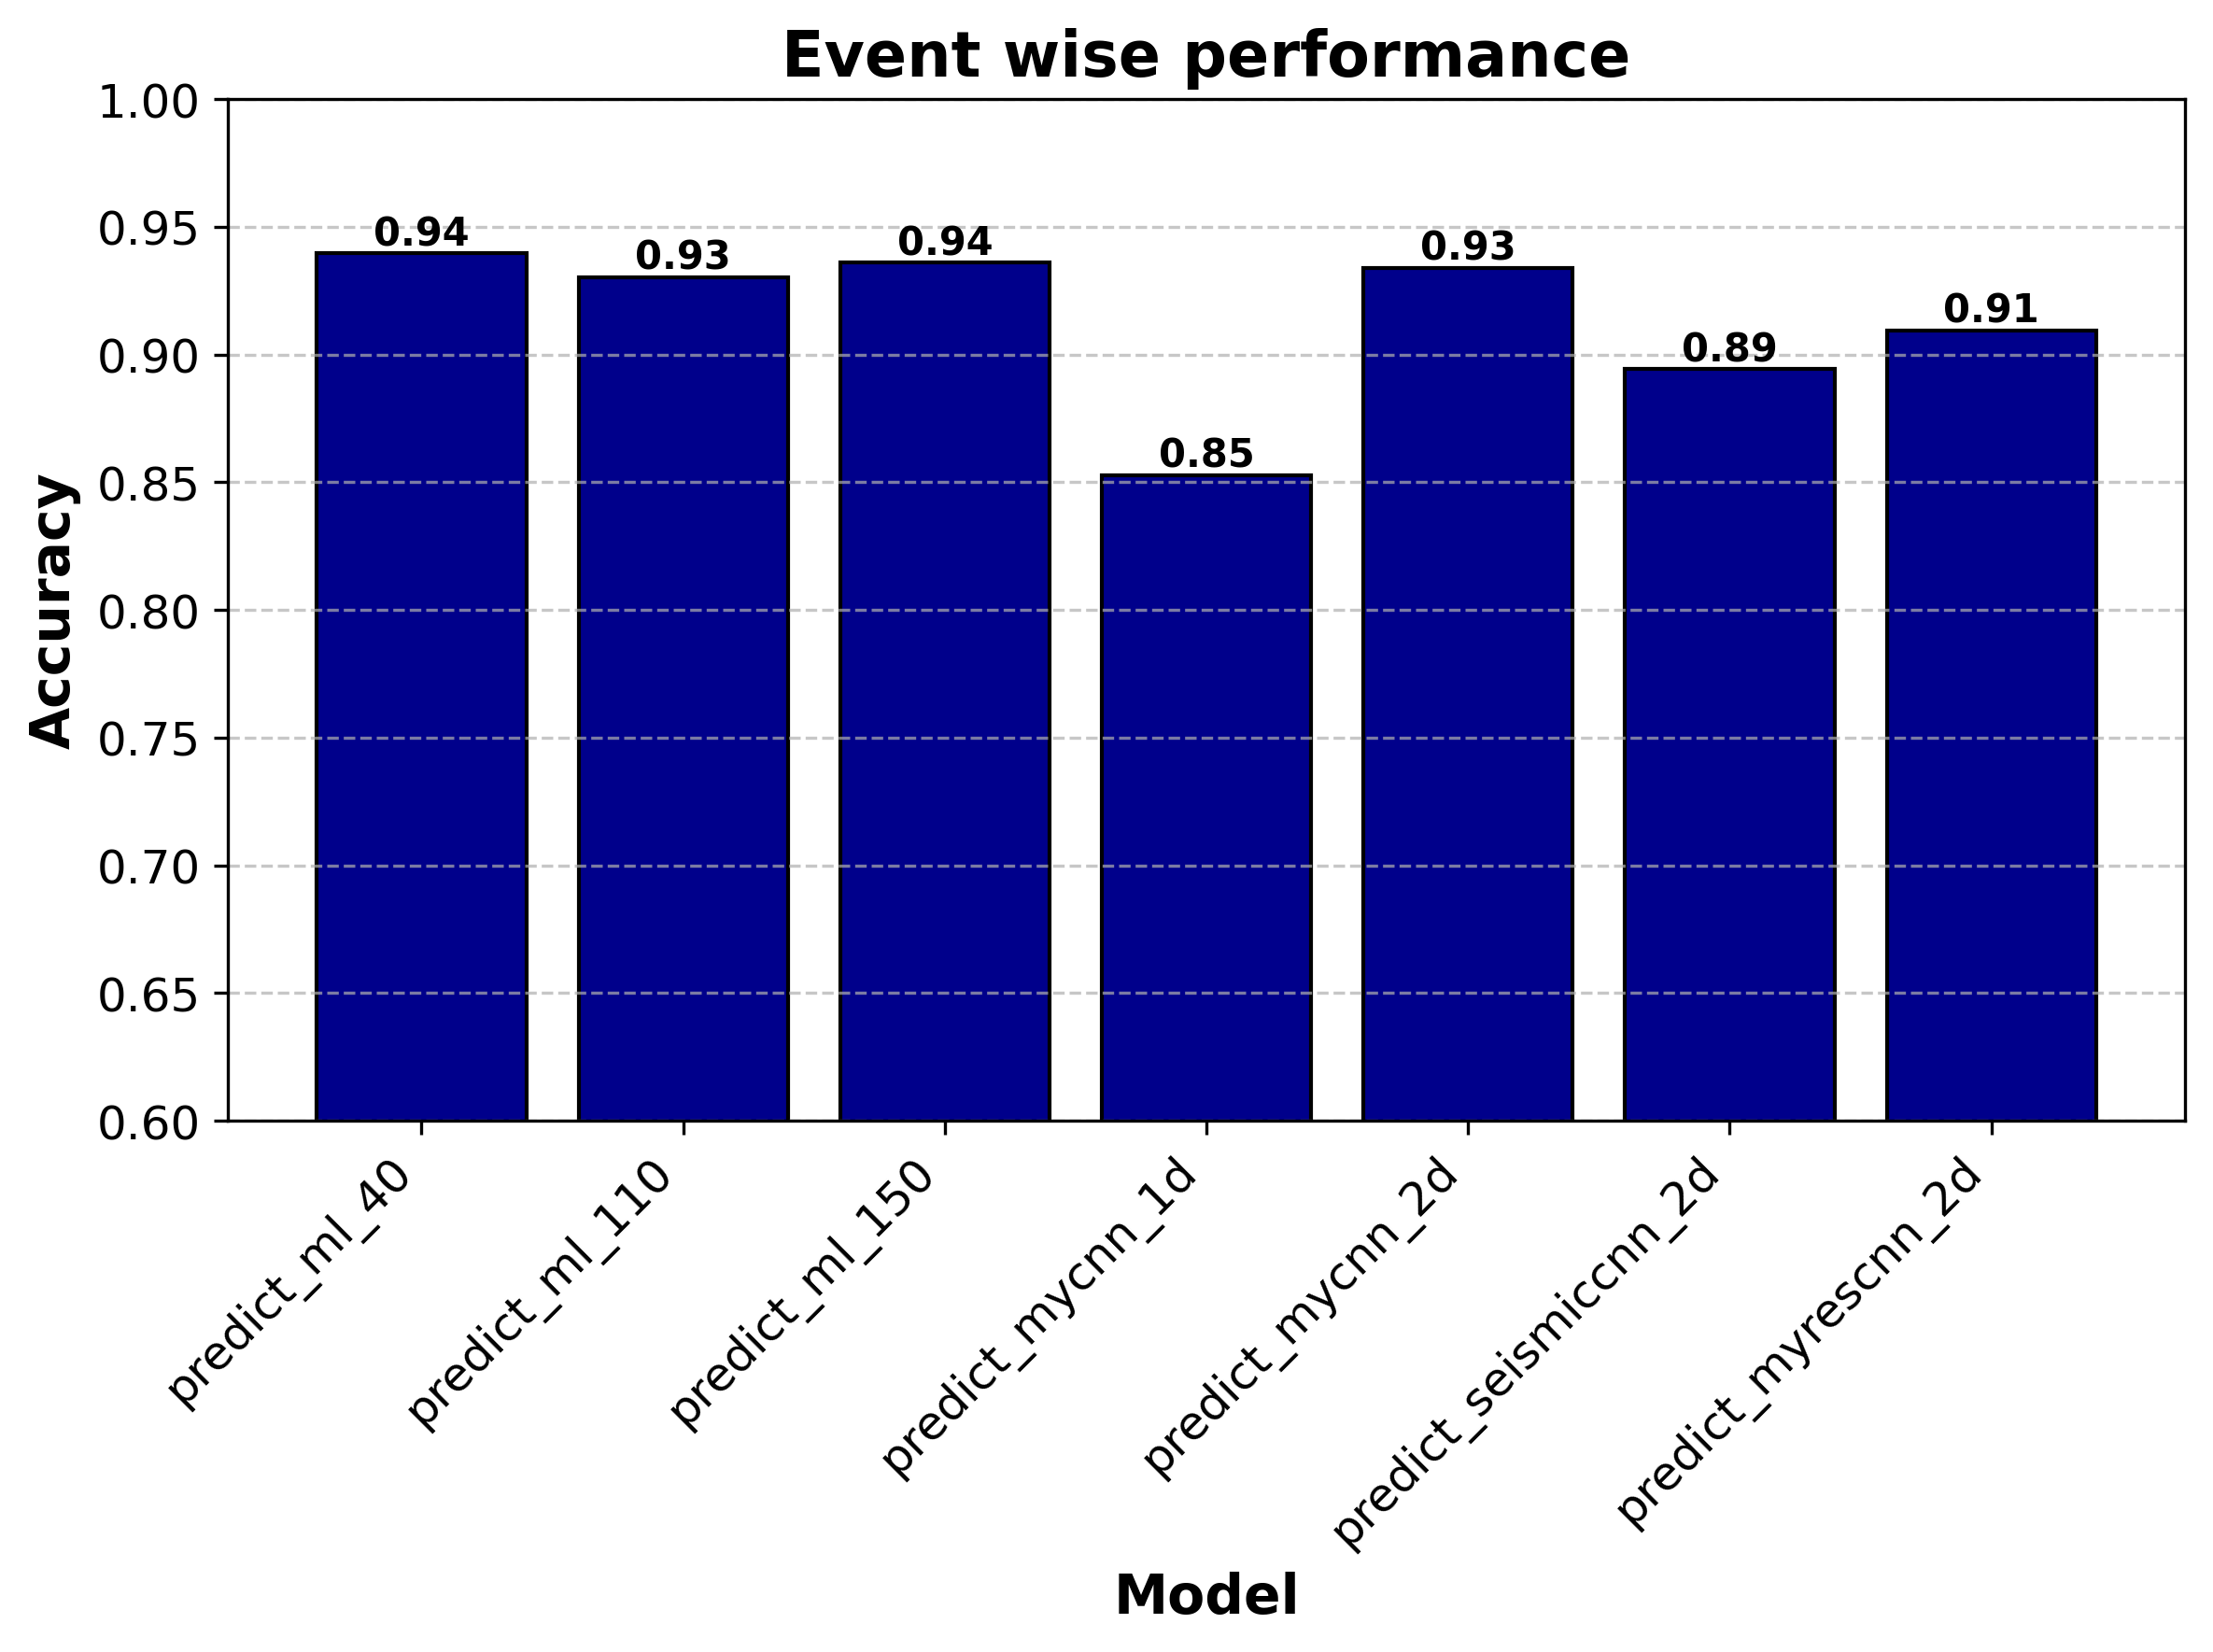

In [22]:
# List of model columns for prediction
model_columns = [
    'predict_ml_40', 'predict_ml_110', 'predict_ml_150', 
    'predict_mycnn_1d', 'predict_mycnn_2d', 
    'predict_seismiccnn_2d', 'predict_myrescnn_2d'
]

# Dictionary to store the accuracy for each model
accuracy_dict = {}

# Loop through each model column and calculate accuracy
for model in model_columns:
    correct_predictions = (df_final[model] == df_final['analyst']).sum()
    total_predictions = len(df_final)
    accuracy = correct_predictions / total_predictions
    accuracy_dict[model] = accuracy

# Display the accuracy for each model
for model, accuracy in accuracy_dict.items():
    print(f"Accuracy for {model}: {accuracy:.4f}")

    
# Extract model names and accuracies
models = list(accuracy_dict.keys())
accuracies = list(accuracy_dict.values())

# Set figure size for a professional research-quality look
plt.figure(figsize=(8, 6), dpi=300)

# Create bar plot
bars = plt.bar(models, accuracies, color='darkblue', edgecolor='black')

# Add labels and title
plt.xlabel('Model', fontsize=14, weight='bold')
plt.ylabel('Accuracy', fontsize=14, weight='bold')
plt.title('Event wise performance', fontsize=16, weight='bold')

# Customize axis ticks
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add accuracy values on top of bars with professional formatting
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# setting ylim
plt.ylim(0.6,1)

# Ensure tight layout for presentation
plt.tight_layout()

# Show plot
plt.show()


In [23]:
df_stations

,stations,distances,analyst,predict_ml_40,predict_ml_110,predict_ml_150,predict_mycnn_1d,predict_mycnn_2d,predict_seismiccnn_2d,predict_myrescnn_2d,snr,eq_ml_40,exp_ml_40,no_ml_40,su_ml_40,eq_ml_110,exp_ml_110,no_ml_110,su_ml_110,eq_ml_150,exp_ml_150,no_ml_150,su_ml_150,eq_mycnn_1d,exp_mycnn_1d,no_mycnn_1d,su_mycnn_1d,eq_mycnn_2d,exp_mycnn_2d,no_mycnn_2d,su_mycnn_2d,eq_seismiccnn_2d,exp_seismiccnn_2d,no_seismiccnn_2d,su_seismiccnn_2d,eq_myrescnn_2d,exp_myrescnn_2d,no_myrescnn_2d,su_myrescnn_2d
61503223,UW.SAXON,10,eq,eq,eq,eq,eq,eq,eq,eq,9.861983,0.854,0.208,0.988,0.158,0.950,0.086,0.882,0.442,0.950,0.106,0.868,0.404,0.982700,0.155467,0.993687,0.864462,0.987675,0.045603,0.996898,0.115453,0.999957,0.053622,0.984570,0.416244,0.991506,0.203085,0.999992,0.455505
61503223,UW.MULN,14,eq,eq,eq,eq,su,eq,eq,eq,18.513825,0.914,0.300,0.960,0.470,0.918,0.116,0.898,0.512,0.942,0.080,0.926,0.392,0.840366,0.222226,0.993736,0.876113,0.940953,0.068016,0.995936,0.723160,0.994367,0.016310,0.982948,0.865707,0.972328,0.371875,1.000000,0.040718
61503223,UW.MBW2,18,eq,eq,eq,eq,eq,eq,eq,eq,4.086573,0.954,0.412,1.000,0.440,0.980,0.156,0.998,0.454,0.968,0.264,0.974,0.312,0.880737,0.134344,0.998516,0.792022,0.989127,0.150942,0.995873,0.378617,0.999432,0.089123,0.998794,0.468731,0.998586,0.105447,0.999919,0.220724
61503223,UW.DONK,28,eq,eq,eq,eq,eq,eq,eq,eq,-1.395581,0.976,0.282,0.998,0.362,0.978,0.104,1.000,0.268,0.974,0.152,0.990,0.242,0.977813,0.014038,0.998011,0.290019,0.987141,0.036496,0.997322,0.110850,0.998578,0.032859,0.999290,0.012953,0.999329,0.208952,0.999994,0.180191
61503223,UW.SHUK,34,eq,eq,eq,eq,su,eq,eq,eq,-0.027120,0.834,0.200,0.996,0.344,0.798,0.164,1.000,0.344,0.756,0.094,0.996,0.438,0.365824,0.113259,0.991741,0.374330,0.979144,0.015827,0.996115,0.033706,0.997415,0.037044,0.997686,0.022349,0.999234,0.039821,0.999999,0.056202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62049261,UW.MOX,38,eq,eq,eq,eq,eq,eq,eq,eq,-2.665018,0.596,0.174,1.000,0.476,0.632,0.198,1.000,0.410,0.530,0.190,0.996,0.266,0.125441,0.009902,0.997214,0.019910,0.823079,0.073899,0.995909,0.392958,0.961232,0.052048,0.998715,0.174065,0.973470,0.006606,0.999976,0.061860
62049306,UW.MDW,19,eq,eq,eq,eq,eq,eq,eq,eq,9.307296,0.970,0.258,0.984,0.174,0.988,0.052,0.948,0.422,0.972,0.050,0.948,0.296,0.900153,0.214274,0.984866,0.801668,0.978757,0.074612,0.996829,0.335041,0.988623,0.094171,0.990393,0.921018,0.959657,0.338625,0.999925,0.204233
62049306,UW.CCRK,28,eq,eq,eq,eq,eq,eq,eq,eq,4.491293,0.898,0.300,0.994,0.506,0.846,0.120,0.940,0.584,0.890,0.072,0.952,0.348,0.990356,0.032194,0.992598,0.923167,0.980828,0.112699,0.996494,0.159175,0.998856,0.588689,0.998285,0.870654,0.899528,0.895775,0.999976,0.103953
62049306,UW.SNI2,33,eq,eq,eq,eq,su,eq,eq,eq,0.039961,0.792,0.276,1.000,0.580,0.728,0.304,1.000,0.402,0.764,0.238,0.998,0.390,0.484718,0.029771,0.997697,0.655779,0.750120,0.058151,0.996490,0.372983,0.936338,0.113601,0.997315,0.537611,0.978491,0.076412,1.000000,0.030416


## Plotting the fraction of traces misclassified in a given bin

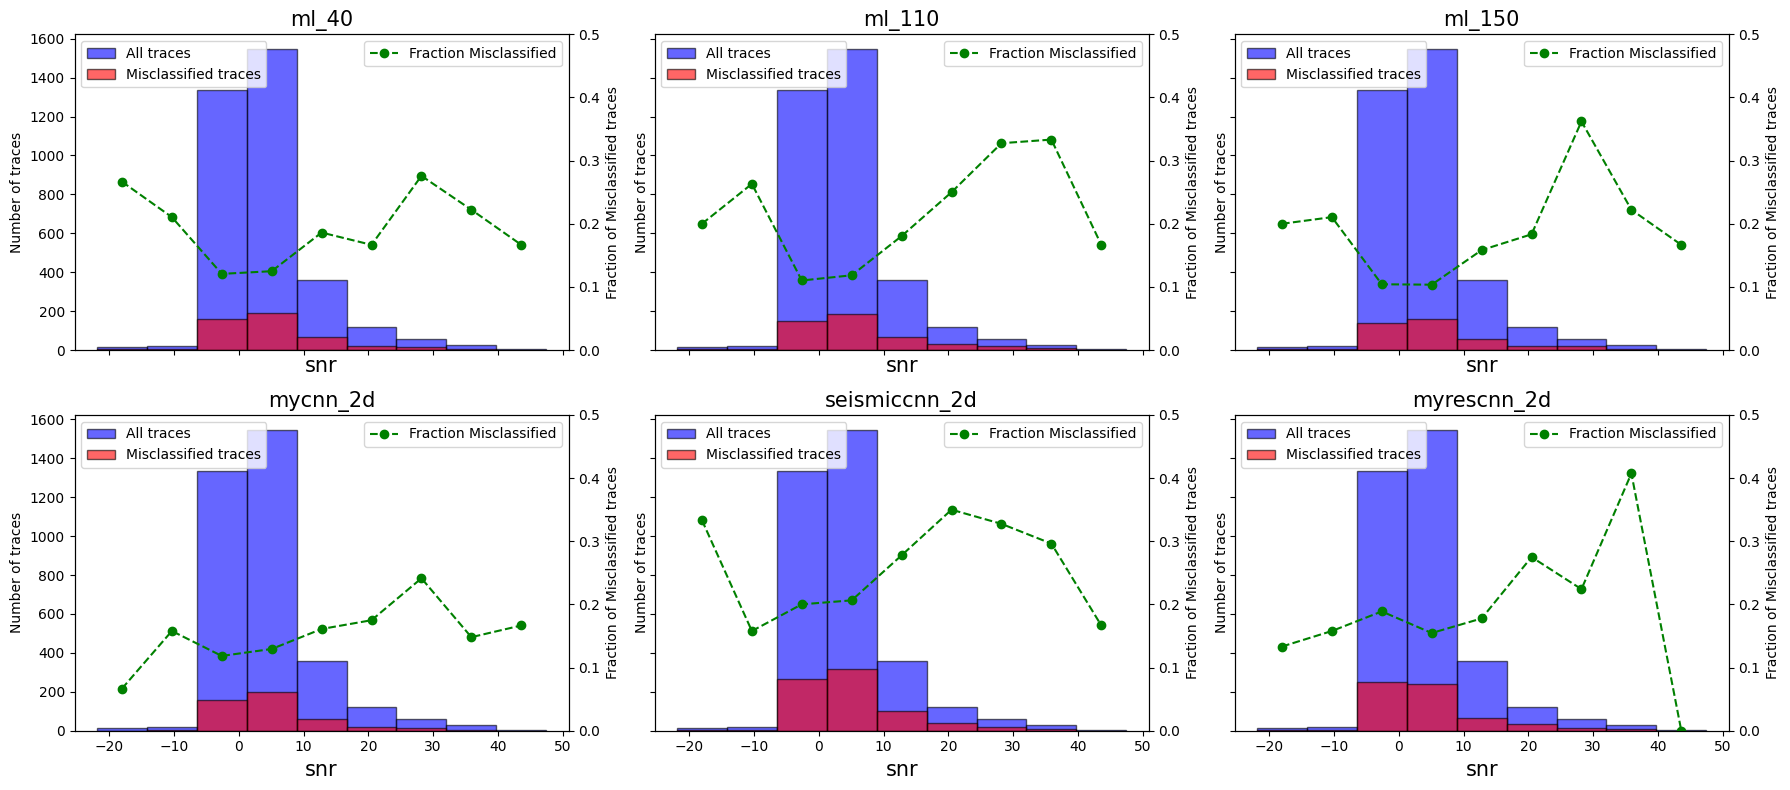

In [24]:
feature_column = 'snr'
# List of models to evaluate
model_columns = [
    'predict_ml_40', 'predict_ml_110', 'predict_ml_150',
    'predict_mycnn_2d', 'predict_seismiccnn_2d', 'predict_myrescnn_2d'
]

# Define SNR bins
snr_bins = np.linspace(df_stations[feature_column].min(), df_stations[feature_column].max(), 10)

# Create the subplots (2x3)
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex = True, sharey = True)
axes = axes.ravel()  # Flatten the 2D array of axes into a 1D array for easy iteration

# Loop over each model and plot in a separate subplot
for i, model_column in enumerate(model_columns):
    # Create masks for correct and incorrect classifications
    correct_mask = df_stations[model_column] == df_stations['analyst']
    incorrect_mask = df_stations[model_column] != df_stations['analyst']

    # Get the SNR values and misclassification status
    snr_values = df_stations[feature_column]
    misclassified_snr = df_stations.loc[incorrect_mask, feature_column]

    # Calculate total events and misclassified events in each bin
    total_events_per_bin, bin_edges = np.histogram(snr_values, bins=snr_bins)
    misclassified_events_per_bin, _ = np.histogram(misclassified_snr, bins=snr_bins)

    # Calculate the fraction of misclassified events in each bin
    fraction_misclassified = misclassified_events_per_bin / total_events_per_bin

    # Handle cases where total_events_per_bin is 0 to avoid division by zero
    fraction_misclassified = np.nan_to_num(fraction_misclassified)

    # Plot histograms
    ax1 = axes[i]

    # Plot the histogram of all SNRs
    ax1.hist(snr_values, bins=snr_bins, alpha=0.6, label='All traces', color='blue', edgecolor='black')

    # Overlay the histogram of misclassified SNRs
    ax1.hist(misclassified_snr, bins=snr_bins, alpha=0.6, label='Misclassified traces', color='red', edgecolor='black')

    # Set labels for the first axis
    ax1.set_xlabel(feature_column, fontsize = 15)
    ax1.set_ylabel('Number of traces')
    ax1.set_title(model_column.split('_', 1)[1], fontsize = 15)

    # Create twin axis for the fraction of misclassified events
    ax2 = ax1.twinx()

    # Get the center of each bin for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot the fraction of misclassified events
    ax2.plot(bin_centers, fraction_misclassified, label='Fraction Misclassified', color='green', marker='o', linestyle='--')
    ax2.set_ylabel('Fraction of Misclassified traces')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    ax2.set_ylim(0,0.5)
# Adjust the layout so that subplots fit nicely
plt.tight_layout()

# Show the plot
plt.show()


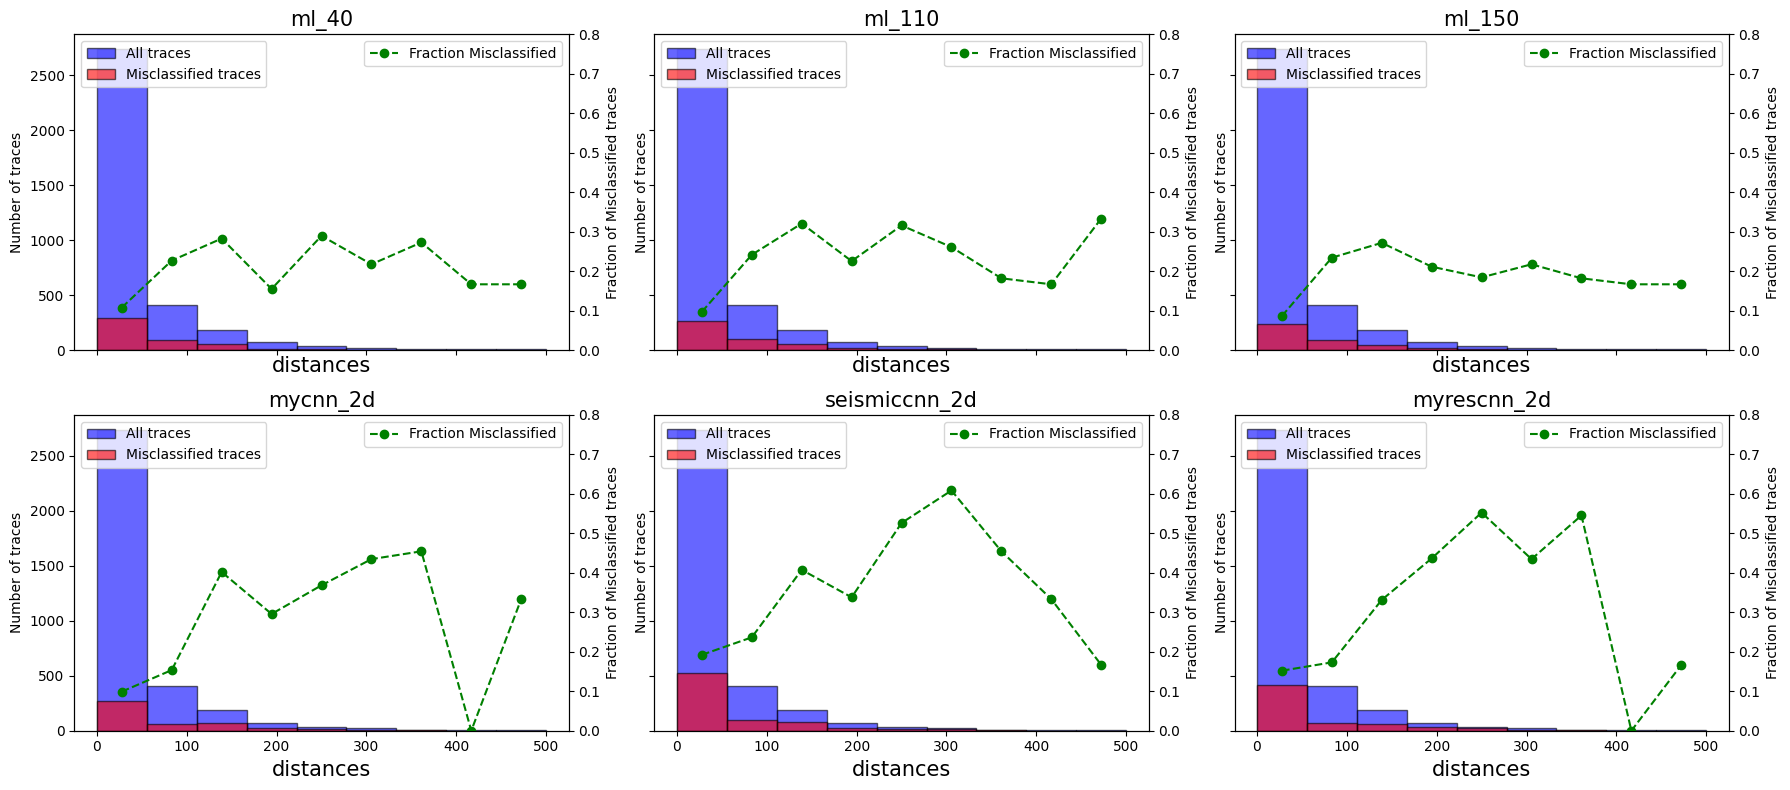

In [25]:
feature_column = 'distances'
# List of models to evaluate
model_columns = [
    'predict_ml_40', 'predict_ml_110', 'predict_ml_150',
    'predict_mycnn_2d', 'predict_seismiccnn_2d', 'predict_myrescnn_2d'
]

# Define SNR bins
snr_bins = np.linspace(df_stations[feature_column].min(), df_stations[feature_column].max(), 10)

# Create the subplots (2x3)
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex = True, sharey = True)
axes = axes.ravel()  # Flatten the 2D array of axes into a 1D array for easy iteration

# Loop over each model and plot in a separate subplot
for i, model_column in enumerate(model_columns):
    # Create masks for correct and incorrect classifications
    correct_mask = df_stations[model_column] == df_stations['analyst']
    incorrect_mask = df_stations[model_column] != df_stations['analyst']

    # Get the SNR values and misclassification status
    snr_values = df_stations[feature_column]
    misclassified_snr = df_stations.loc[incorrect_mask, feature_column]

    # Calculate total events and misclassified events in each bin
    total_events_per_bin, bin_edges = np.histogram(snr_values, bins=snr_bins)
    misclassified_events_per_bin, _ = np.histogram(misclassified_snr, bins=snr_bins)

    # Calculate the fraction of misclassified events in each bin
    fraction_misclassified = misclassified_events_per_bin / total_events_per_bin

    # Handle cases where total_events_per_bin is 0 to avoid division by zero
    fraction_misclassified = np.nan_to_num(fraction_misclassified)

    # Plot histograms
    ax1 = axes[i]

    # Plot the histogram of all SNRs
    ax1.hist(snr_values, bins=snr_bins, alpha=0.6, label='All traces', color='blue', edgecolor='black')

    # Overlay the histogram of misclassified SNRs
    ax1.hist(misclassified_snr, bins=snr_bins, alpha=0.6, label='Misclassified traces', color='red', edgecolor='black')

    # Set labels for the first axis
    ax1.set_xlabel(feature_column, fontsize = 15)
    ax1.set_ylabel('Number of traces')
    ax1.set_title(model_column.split('_', 1)[1], fontsize = 15)

    # Create twin axis for the fraction of misclassified events
    ax2 = ax1.twinx()

    # Get the center of each bin for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot the fraction of misclassified events
    ax2.plot(bin_centers, fraction_misclassified, label='Fraction Misclassified', color='green', marker='o', linestyle='--')
    ax2.set_ylabel('Fraction of Misclassified traces')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    ax2.set_ylim(0,0.8)
# Adjust the layout so that subplots fit nicely
plt.tight_layout()

# Show the plot
plt.show()


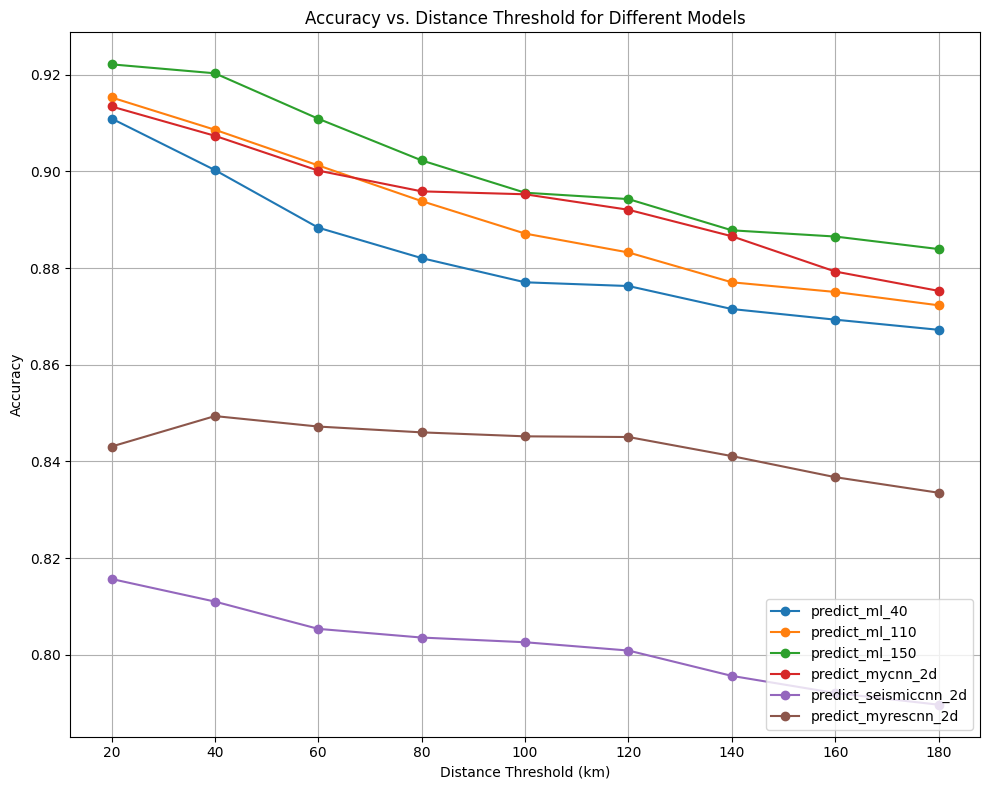

In [26]:
# Define distance thresholds (you can adjust this based on your needs)
distance_thresholds = np.arange(20, 200, 20)  # Thresholds from 0 to 40 with a step of 5

# List of models to evaluate
model_columns = [
    'predict_ml_40', 'predict_ml_110', 'predict_ml_150',
    'predict_mycnn_2d', 'predict_seismiccnn_2d', 'predict_myrescnn_2d'
]

# Dictionary to store accuracies for each model with varying distance thresholds
accuracy_dict = {model: [] for model in model_columns}

# Loop through each distance threshold
for threshold in distance_thresholds:
    # Filter dataframe based on the distance threshold
    df_filtered = df_stations[df_stations['distances'] <= threshold]
    
    # Calculate accuracy for each model at this distance threshold
    for model in model_columns:
        if len(df_filtered) > 0:
            correct_predictions = (df_filtered[model] == df_filtered['analyst']).sum()
            total_predictions = len(df_filtered)
            accuracy = correct_predictions / total_predictions
        else:
            accuracy = 0  # If no events fall within the threshold, set accuracy to 0
        accuracy_dict[model].append(accuracy)

# Plot accuracy vs. distance threshold for each model
plt.figure(figsize=(10, 8))

for model in model_columns:
    plt.plot(distance_thresholds, accuracy_dict[model], marker='o', label=model)

# Add labels and legend
plt.xlabel('Distance Threshold (km)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Distance Threshold for Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


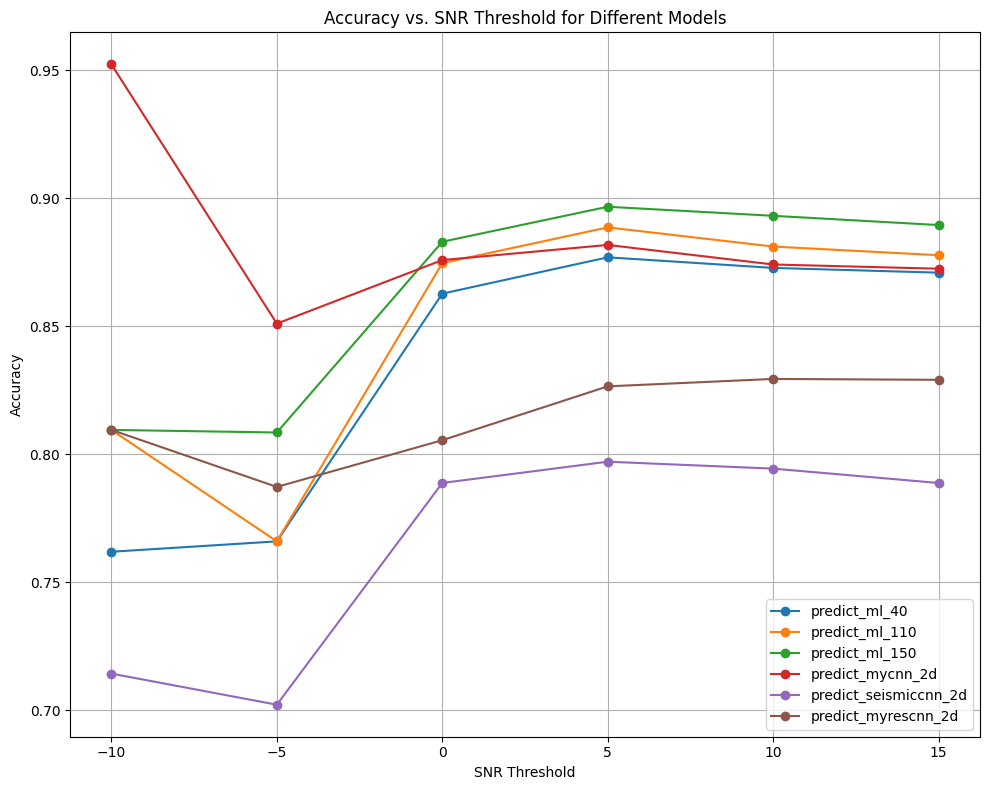

In [27]:
# Define distance thresholds (you can adjust this based on your needs)
distance_thresholds = np.arange(-10, 20, 5)  # Thresholds from 0 to 40 with a step of 5

# List of models to evaluate
model_columns = [
    'predict_ml_40', 'predict_ml_110', 'predict_ml_150',
    'predict_mycnn_2d', 'predict_seismiccnn_2d', 'predict_myrescnn_2d'
]

# Dictionary to store accuracies for each model with varying distance thresholds
accuracy_dict = {model: [] for model in model_columns}

# Loop through each distance threshold
for threshold in distance_thresholds:
    # Filter dataframe based on the distance threshold
    df_filtered = df_stations[df_stations['snr'] <= threshold]
    
    # Calculate accuracy for each model at this distance threshold
    for model in model_columns:
        if len(df_filtered) > 0:
            correct_predictions = (df_filtered[model] == df_filtered['analyst']).sum()
            total_predictions = len(df_filtered)
            accuracy = correct_predictions / total_predictions
        else:
            accuracy = 0  # If no events fall within the threshold, set accuracy to 0
        accuracy_dict[model].append(accuracy)

# Plot accuracy vs. distance threshold for each model
plt.figure(figsize=(10, 8))

for model in model_columns:
    plt.plot(distance_thresholds, accuracy_dict[model], marker='o', label=model)

# Add labels and legend
plt.xlabel('SNR Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. SNR Threshold for Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


## Computing the accuracies v.s threshold curve

In [28]:
# List of models for which you want to compute the max probabilities
models = ['ml_40', 'ml_110', 'ml_150', 'mycnn_1d', 'mycnn_2d', 'seismiccnn_2d', 'myrescnn_2d']

# Loop through each model and calculate the max probability
for model in models:
    # Create a new column 'max_prob_{model}' which stores the maximum of eq, exp, no, and su probabilities for that model
    df_stations[f'max_prob_{model}'] = df_stations[[f'eq_{model}', f'exp_{model}', f'su_{model}']].max(axis=1)


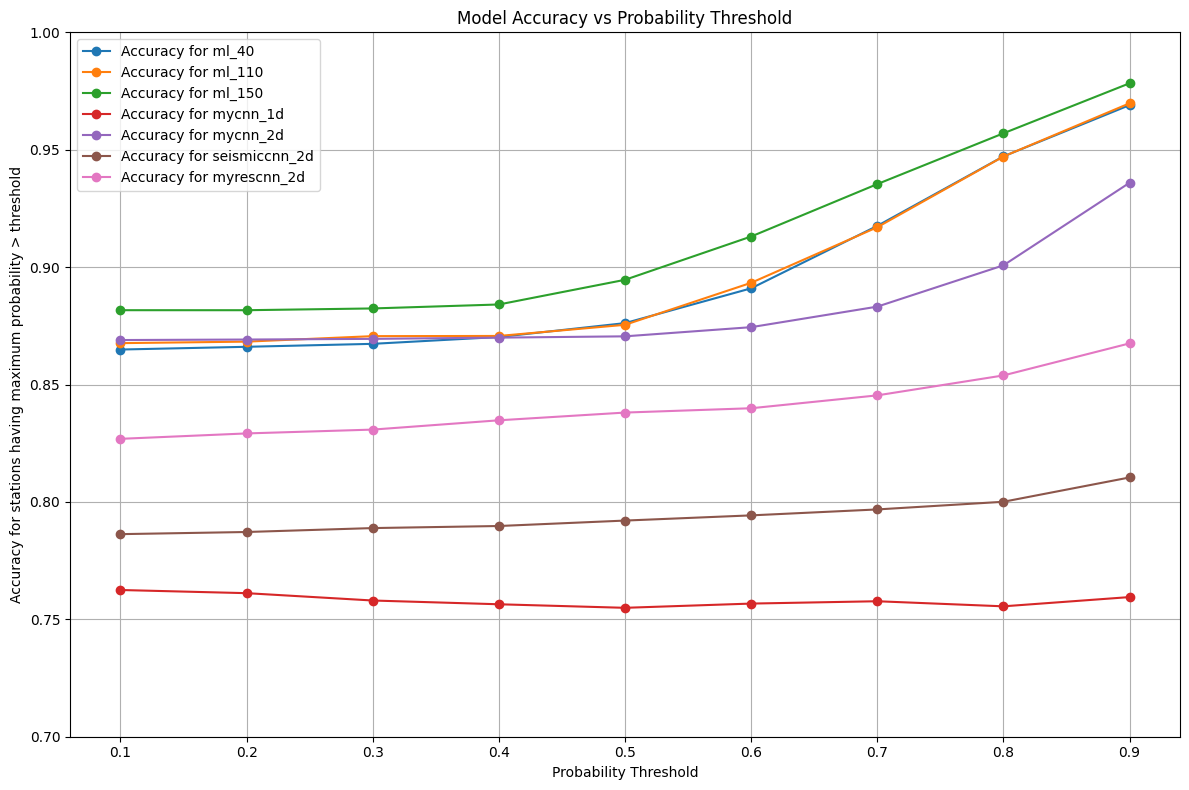

In [29]:
# Assuming df_stations is your DataFrame and already has max_prob_{model} columns

# Define the models and the thresholds
models = ['ml_40', 'ml_110', 'ml_150', 'mycnn_1d', 'mycnn_2d', 'seismiccnn_2d', 'myrescnn_2d']
thresholds = np.arange(0.1, 1.0, 0.1)

# Initialize a dictionary to hold accuracies for each model
accuracy_dict = {model: [] for model in models}

# Loop through each model and threshold to calculate accuracy
for model in models:
    for threshold in thresholds:
        # Select rows where max_prob_{model} is greater than the threshold
        filtered_df = df_stations[df_stations[f'max_prob_{model}'] > threshold]
        
        # Calculate accuracy: correct predictions / total predictions in filtered_df
        correct_predictions = (filtered_df[f'predict_{model}'] == filtered_df['analyst']).sum()
        total_predictions = len(filtered_df)
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0  # Avoid division by zero
        
        # Store the accuracy for the model at this threshold
        accuracy_dict[model].append(accuracy)

# Plotting the accuracy curves
plt.figure(figsize=(12, 8))
for model in models:
    plt.plot(thresholds, accuracy_dict[model], marker='o', label=f'Accuracy for {model}')

# Adding labels and title
plt.xlabel('Probability Threshold')
plt.ylabel('Accuracy for stations having maximum probability > threshold')
plt.title('Model Accuracy vs Probability Threshold')
plt.xticks(thresholds)  # Set x-ticks to be the thresholds
plt.ylim(0.7, 1)  # Set y-limits for accuracy
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


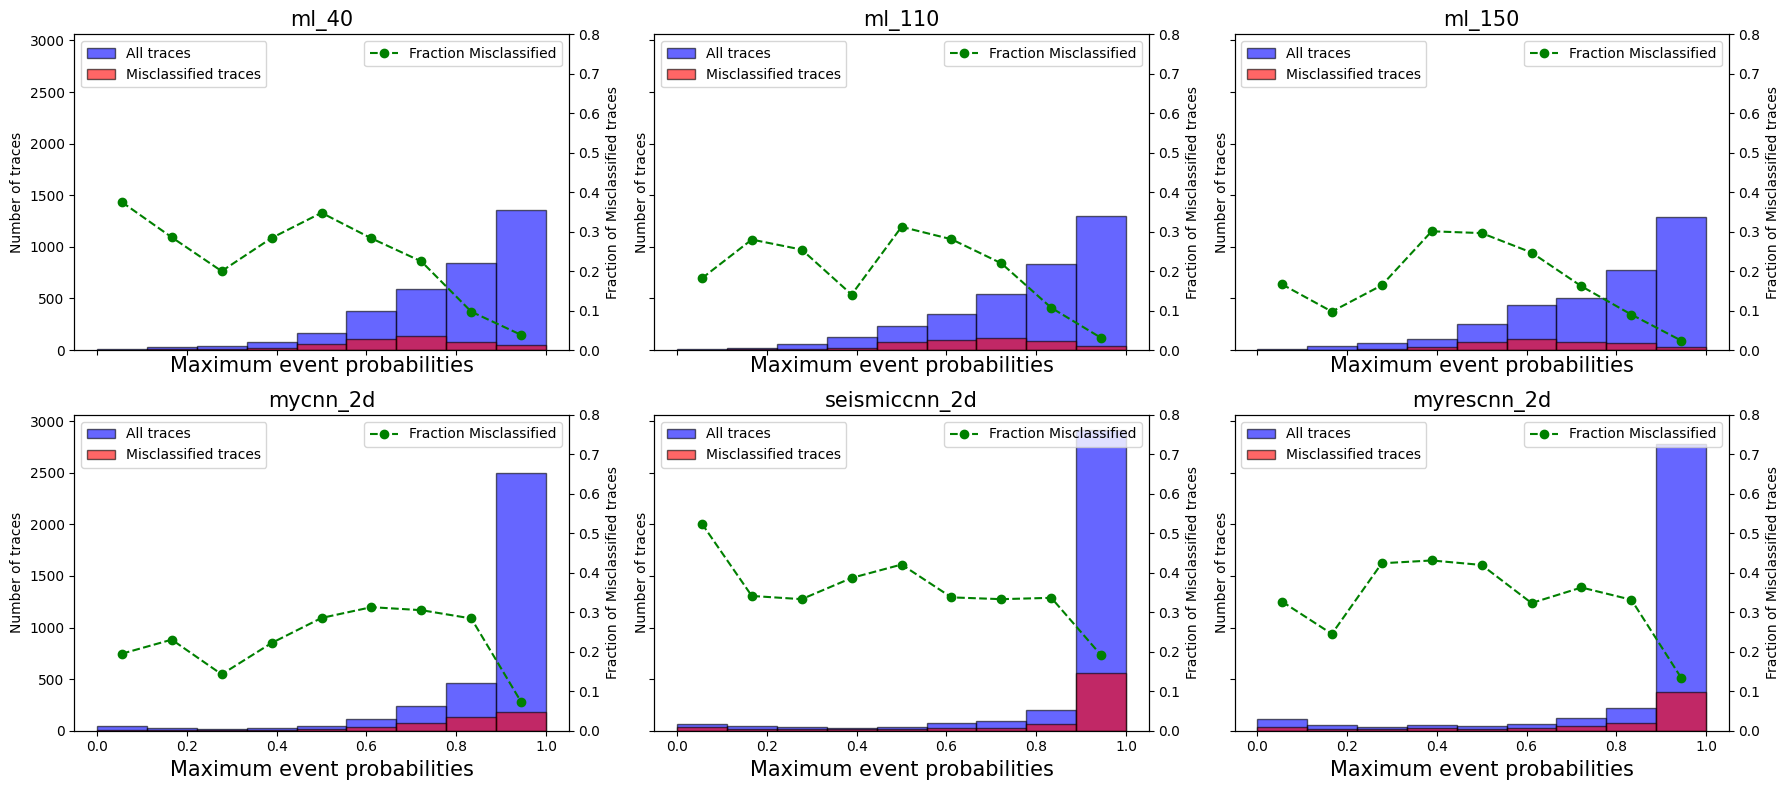

In [30]:
# Define the models and the thresholds
models = ['ml_40', 'ml_110', 'ml_150', 'mycnn_2d', 'seismiccnn_2d', 'myrescnn_2d']


# List of models to evaluate
model_columns = [
    'predict_ml_40', 'predict_ml_110', 'predict_ml_150',
    'predict_mycnn_2d', 'predict_seismiccnn_2d', 'predict_myrescnn_2d'
]

# Define SNR bins
snr_bins = np.linspace(0, 1, 10)

# Create the subplots (2x3)
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex = True, sharey = True)
axes = axes.ravel()  # Flatten the 2D array of axes into a 1D array for easy iteration

# Loop over each model and plot in a separate subplot
for i, model in enumerate(models):
    
    # Create masks for correct and incorrect classifications
    correct_mask = df_stations[f'predict_{model}'] == df_stations['analyst']
    incorrect_mask = df_stations[f'predict_{model}'] != df_stations['analyst']

    # Get the SNR values and misclassification status
    snr_values = df_stations[f'max_prob_{model}']
    misclassified_snr = df_stations.loc[incorrect_mask, f'max_prob_{model}']

    # Calculate total events and misclassified events in each bin
    total_events_per_bin, bin_edges = np.histogram(snr_values, bins=snr_bins)
    misclassified_events_per_bin, _ = np.histogram(misclassified_snr, bins=snr_bins)

    # Calculate the fraction of misclassified events in each bin
    fraction_misclassified = misclassified_events_per_bin / total_events_per_bin

    # Handle cases where total_events_per_bin is 0 to avoid division by zero
    fraction_misclassified = np.nan_to_num(fraction_misclassified)

    # Plot histograms
    ax1 = axes[i]

    # Plot the histogram of all SNRs
    ax1.hist(snr_values, bins=snr_bins, alpha=0.6, label='All traces', color='blue', edgecolor='black')

    # Overlay the histogram of misclassified SNRs
    ax1.hist(misclassified_snr, bins=snr_bins, alpha=0.6, label='Misclassified traces', color='red', edgecolor='black')

    # Set labels for the first axis
    ax1.set_xlabel("Maximum event probabilities", fontsize = 15)
    ax1.set_ylabel('Number of traces')
    ax1.set_title(f'{model}', fontsize = 15)

    # Create twin axis for the fraction of misclassified events
    ax2 = ax1.twinx()

    # Get the center of each bin for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot the fraction of misclassified events
    ax2.plot(bin_centers, fraction_misclassified, label='Fraction Misclassified', color='green', marker='o', linestyle='--')
    ax2.set_ylabel('Fraction of Misclassified traces')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    ax2.set_ylim(0,0.8)
# Adjust the layout so that subplots fit nicely
plt.tight_layout()

# Show the plot
plt.show()
